# Project 4 - Lending Club Capstone Project
Xue Wang

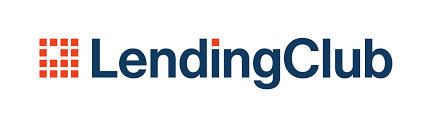

In [1]:
from IPython.display import Image
Image(filename='lending club.png')

**Business model of LendingClub**  
- 2006 - 2020, P2P consumer lending business
    * attractive to borrowers
    * attractive to lenders


- post 2020, neobank
    * ended P2P businesses
    * transformed to a neobank

In [2]:
#Image(filename='lending club.jpg')

## Goal  
From an external analyst perspective, this project aims to inspect what happened to LendingClub the company, and why it tried to move away from P2P industry. I also wish to explore the future outlook of both the company and the P2P industry.

***Major questions this project trying to answer***  
(1) Whether LendingClub is offering attractive returns for investors, and whether advanced techniques could help investors increase returns.  
(2) With additional data related to macroeconomic conditions, how default probability of borrowers would be affected during time of uncertainty.  

***Measure of success***  
(1) Success is measured by the improvement of investment results based on my model.  
(2) Furthermore, success is being able to interpret the data from 2007 through 2018 and making a reasonable interpretation of the company’s situation and competitive position that makes business sense.

## Datasets

**LC data**
* Source: LendingClub's dataset, 2007-2018Q4 (https://www.kaggle.com/wordsforthewise/lending-club)
* 2,260,701 Accepted loans with 151 attributes
* 2,764,8741 rejected loans with 9 attributes
* Variables includes loan status, loan features, borrowers’ current and historical credit info etc.

**Additionals**
* National annual CPI
* National annual real GDP growth rate
* State monthly umemployment rate

In [3]:
import numpy as np
import pandas as pd
import matplotlib
#%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display

import math

## Load data

**1. LC Loan data**

In [4]:
### accepted
accepted = pd.read_csv('data/accepted_2007_to_2018Q4.csv')#, index_col=0)

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
### rejected
#rejected = pd.read_csv('data/rejected_2007_to_2018Q4.csv')#, index_col=0)

In [6]:
print(accepted.shape) #(2260701, 151)
#print(rejected.shape)

(2260701, 151)


In [7]:
### save original copies


**Preliminary Check:**

***- Data type***

In [8]:
#pd.set_option('display.max_rows', 500)
#accepted.dtypes

***- NaN values***

In [9]:
accepted_null = pd.DataFrame(pd.isnull(accepted).sum().sort_values(ascending=False)[pd.isnull(accepted).sum().sort_values(ascending=False) >0]).reset_index()
print(accepted_null.shape)

(150, 2)


In [10]:
accepted_null.head()

,index,0
0,member_id,2260701
1,orig_projected_additional_accrued_interest,2252050
2,hardship_end_date,2249784
3,hardship_start_date,2249784
4,hardship_type,2249784


In [11]:
accepted_null.columns = ['attribute','cnt']
accepted_null['null_pct'] = accepted_null['cnt'].div(accepted.shape[0])

### Check full result
#pd.set_option('display.max_rows', 500)
#accepted_null

### Write to local
#accepted_null.to_csv('data/null_columns.csv') 

In [12]:
#pd.isnull(accepted.loc[np.isnan(accepted.fico_range_low)]).sum() # all 33 verified

There are 33 records which attributes (excl. 'id') are all missing.  
Thus, directly delete these 33 rows/records.  
All Other NaN values will be processed upon analysis or in data preprocessing for modeling.

In [13]:
accepted = accepted.dropna(subset=['fico_range_low']).copy()
accepted.shape

(2260668, 151)

***- Unique id***

In [14]:
accepted.id.nunique()

2260668

In [15]:
accepted.id.dtypes

dtype('O')

'id' is the unique id for each loans

**2. Macroecon datasets**

In [16]:
### US annual CPI
cpi = pd.read_csv('data/US_CPI.csv')#, index_col=0) # national

#### US annual real GDP growth rate
gdp = pd.read_csv('data/US_GDP.csv')#, index_col=0) # national
gdp['gdp_growth'] = gdp['Value'].pct_change()*100

### State monthly umemployment rate
unemployment = pd.read_csv('data/US_statewide_unemployment_rate.csv')#, index_col=0) # state

  
******
  

******
## Functions

In [17]:
#def default_by_feature(feature,feature2,size,sort,df0=accepted):
def default_by_feature(feature,feature2,size,sort,df0):
    
    #df = df0.groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()
    df = df0[df0.loan_status2.isin(['Fully Paid','Default'])].groupby([feature,'loan_status2'],dropna=False).agg({'id':'count','funded_amnt':'sum'}).reset_index()
    df.columns = [feature,'loan_status2','count','amount']
    df['count_pct'] = df.groupby([feature],dropna=False)['count'].apply(lambda x: x*100/x.sum())
    #df
    df[feature] = df[feature].fillna('Missing')
    
    if sort =='y':
        df = df.sort_values(by= 'count_pct' , ascending=True)

    if size == 'small':
        plt.figure(figsize=(10,6))
    else:
        plt.figure(figsize=(20,6))
        
    #grade_order = ['A','B','C','D','E','F','G']
    status_order = ['Fully Paid','Default']

    g = sns.barplot(x=feature, 
                 y= 'count_pct',
                  hue="loan_status2",
                  #palette="pastel", 
                 #edgecolor=".3",
                  data=df,
                 #sort='False',
                 #order=issue_d_order,
                  hue_order = status_order)

    plt.xlabel(feature2,fontsize=15)#,rotation = 45)
    #plt.xticks(rotation=20)
    plt.ylabel('%',fontsize=15)
    plt.legend(title='Loan Status')
    #plt.legend().remove()
    plt.title('Loan Status by {}'.format(feature2.title()),fontsize=15)

    plt.show(g)

In [18]:
def classify_features(features):
    df = accepted
    # Numerical Features
    feature_n = df[features].select_dtypes(include=['int64','float64']).columns
    #feature_num = feature_num.drop(['PID','SalePrice'])
    #feature_num = feature_num.drop(['PID'])

    # Categorical Features
    features_c = df[features].select_dtypes(include=['object']).columns
    
    # return numerical & categorical lists
    return list(feature_n), list(features_c)

In [19]:
'''def feature_selection1(feature_list):
    f_num, f_cat = classify_features(feature_list)
    print(f_num)
    print(f_cat)

    # --- VIF ---
    X = accepted[f_num]
  
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    print(vif_data)

    
    # --- Corr matrix ---
    correlation_matrices(f_num)'''

'def feature_selection1(feature_list):\n    f_num, f_cat = classify_features(feature_list)\n    print(f_num)\n    print(f_cat)\n\n    # --- VIF ---\n    X = accepted[f_num]\n  \n    # VIF dataframe\n    vif_data = pd.DataFrame()\n    vif_data["feature"] = X.columns\n    \n    # calculating VIF for each feature\n    vif_data["VIF"] = [variance_inflation_factor(X.values, i)\n                              for i in range(len(X.columns))]\n\n    print(vif_data)\n\n    \n    # --- Corr matrix ---\n    correlation_matrices(f_num)'

## I. EDA

**Main Goals:**  

***1. Understand LC's loan portfolio in terms of their loan features***  
Also find potential features correlated with default and analyze how they are correlated  
        
***2. Analyze return of LC loans***

**Feature engineering**  
Generate new features for analysis

***1. loan status***

In [20]:
accepted.loan_status.value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [21]:
# Fully Paid                                              
# Current                                                 
# Charged Off --> Defalut                                          
# Late (31-120 days) --> late                                       
# In Grace Period    --> late                               
# Late (16-30 days)  --> late                               
# Does not meet the credit policy. Status:Fully Paid     --> Fully paid
# Does not meet the credit policy. Status:Charged Off    --> Default
# Default                                                                                                      

In [22]:
def update_current_loan_status(x):
    if x == 'Charged Off':
        return 'Default'
    elif x == 'In Grace Period':
        return 'Late'
    elif x == 'Late (16-30 days)':
        return 'Late'
    elif x == 'Late (31-120 days)':
        return 'Late'
    elif x == 'Does not meet the credit policy. Status:Fully Paid':
        return 'Fully Paid'
    elif x == 'Does not meet the credit policy. Status:Charged Off':
        return 'Default'
    else:
        return x

### New Feature
accepted['loan_status2'] = accepted['loan_status'].apply(update_current_loan_status)
accepted.loan_status2.value_counts(dropna=False)

Fully Paid    1078739
Current        878317
Default        269360
Late            34252
Name: loan_status2, dtype: int64

In [23]:
# Fully Paid    1078739 --> completed
# Default        269360 --> completed

# Current        878317 --> current
# Late            34252 --> current


**2. issue year**

In [24]:
### New Feature
accepted['issue_yr'] = round(pd.to_datetime(accepted.issue_d).dt.year)

In [25]:
np.sort(accepted.issue_yr.unique())

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

**3. Duration**

In [26]:
'''pd.isnull(accepted[['last_pymnt_d','issue_d']]).sum()'''

"pd.isnull(accepted[['last_pymnt_d','issue_d']]).sum()"

In [27]:
'''temp1 = accepted.loc[pd.isnull(accepted.last_pymnt_d)]
#accepted.loc[pd.isnull(accepted.last_pymnt_d)].to_csv('data/null_last_pymnt_d.csv') 
#temp1.to_csv('data/null_last_pymnt_d.csv') '''

"temp1 = accepted.loc[pd.isnull(accepted.last_pymnt_d)]\n#accepted.loc[pd.isnull(accepted.last_pymnt_d)].to_csv('data/null_last_pymnt_d.csv') \n#temp1.to_csv('data/null_last_pymnt_d.csv') "

In [28]:
'''# temp1
temp1.shape'''

'# temp1\ntemp1.shape'

In [29]:
#accepted.loc[pd.isnull(accepted.last_pymnt_d),'loan_status'].value_counts()

In [30]:
'''temp1['total_pymnt'].equals(temp1['recoveries'])'''

"temp1['total_pymnt'].equals(temp1['recoveries'])"

In [31]:
'''temp1.shape[0] - (temp1['total_pymnt'] == temp1['recoveries']).sum()'''

"temp1.shape[0] - (temp1['total_pymnt'] == temp1['recoveries']).sum()"

In [32]:
'''pd.set_option('display.max_columns', 500)
temp1[temp1['total_pymnt'] != temp1['recoveries']]'''

"pd.set_option('display.max_columns', 500)\ntemp1[temp1['total_pymnt'] != temp1['recoveries']]"

In [33]:
'''import datetime

def months(d1, d2):
    return d1.month - d2.month + 12*(d1.year - d2.year)


accepted['last_pymnt_d2'] = pd.to_datetime(accepted.last_pymnt_d)#.dt#.year
accepted['issue_d2'] = pd.to_datetime(accepted.issue_d)#.dt#.year


### new feature - term_actual
accepted['duration'] = accepted.apply(lambda x: months(x['last_pymnt_d2'], x['issue_d2']), axis=1)'''

"import datetime\n\ndef months(d1, d2):\n    return d1.month - d2.month + 12*(d1.year - d2.year)\n\n\naccepted['last_pymnt_d2'] = pd.to_datetime(accepted.last_pymnt_d)#.dt#.year\naccepted['issue_d2'] = pd.to_datetime(accepted.issue_d)#.dt#.year\n\n\n### new feature - term_actual\naccepted['duration'] = accepted.apply(lambda x: months(x['last_pymnt_d2'], x['issue_d2']), axis=1)"

In [34]:
#accepted.loc[accepted.loan_status2.isin(['Fully Paid']),'duration'].value_counts()

**4. return**

In [35]:
### Method 1

In [36]:
#accepted.total_pymnt

In [37]:
accepted['roi'] = round((round(accepted.total_pymnt,2) / accepted.funded_amnt)-1,4)

In [38]:
accepted['roi'].describe()

count    2.260668e+06
mean    -1.751241e-01
std      3.975369e-01
min     -1.000000e+00
25%     -5.568000e-01
50%      2.220000e-02
75%      1.405000e-01
max      1.170300e+00
Name: roi, dtype: float64

In [39]:
#accepted['roi_inv'] = round((accepted.total_pymnt_inv / accepted.funded_amnt_inv)-1,4)
#accepted[['roi']].equals(accepted['roi_inv'])
#temp1['total_pymnt'].equals(temp1['recoveries'])

In [40]:
#accepted['diff'] = accepted.roi - accepted.roi_inv
#accepted.loc[accepted['diff'] != 0,['funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv']].head()

In [41]:
### Method 2

In [42]:
'''### New Feature -- anuallized ROI
accepted['aroi'] = pow((accepted.total_pymnt / accepted.funded_amnt),(1/(accepted.duration/12)))-1'''

"### New Feature -- anuallized ROI\naccepted['aroi'] = pow((accepted.total_pymnt / accepted.funded_amnt),(1/(accepted.duration/12)))-1"

In [43]:
'''# before return calculation, check nulls
pd.isnull(accepted[['total_pymnt','funded_amnt','duration']]).sum()'''

"# before return calculation, check nulls\npd.isnull(accepted[['total_pymnt','funded_amnt','duration']]).sum()"

In [44]:
'''### New Feature -- anuallized ROI
accepted['aroi'] = pow((accepted.total_pymnt / accepted.funded_amnt),(1/(accepted.duration/12)))-1'''

"### New Feature -- anuallized ROI\naccepted['aroi'] = pow((accepted.total_pymnt / accepted.funded_amnt),(1/(accepted.duration/12)))-1"

In [45]:
'''# Inv side is the same with overall
#pow((accepted.total_pymnt_inv / accepted.funded_amnt_inv),(1/(accepted.duration/12)))-1'''

'# Inv side is the same with overall\n#pow((accepted.total_pymnt_inv / accepted.funded_amnt_inv),(1/(accepted.duration/12)))-1'

In [46]:
'''accepted['aroi'].describe()'''

"accepted['aroi'].describe()"

**5. Subgrade (lable encoded)**

In [47]:
d = {"A1": 1,
"A2": 2 ,
"A3": 3,
"A4": 4,
"A5": 5 ,
"B1": 6 ,
"B2": 7 ,
"B3": 8 ,
"B4": 9 ,
"B5": 10 ,
"C1": 11 ,
"C2": 12 ,
"C3": 13 ,
"C4": 14 ,
"C5": 15 ,
"D1" : 16 ,
"D2" : 17 ,
"D3" : 18 ,
"D4" : 19 ,
"D5" : 20 ,
"E1" : 21 ,
"E2" : 22 ,
"E3" : 23 ,
"E4" : 24 ,
"E5" : 25 ,
"F1" : 26 ,
"F2" : 27 ,
"F3" : 28 ,
"F4" : 29 ,
"F5" : 30 ,
"G1" : 31 ,
"G2" : 32 ,
"G3" : 33 ,
"G4" : 34 ,
"G5" : 35 }

In [48]:
accepted['sub_grade2'] = accepted.sub_grade
accepted.sub_grade2.replace(d, inplace=True)
#accepted.sub_grade2.value_counts(dropna=False)

**6. FICO**

In [49]:
accepted[['fico_range_high', 'fico_range_low', 'sec_app_fico_range_low' , 'sec_app_fico_range_high' ]].isna().sum()

fico_range_high                  0
fico_range_low                   0
sec_app_fico_range_low     2152647
sec_app_fico_range_high    2152647
dtype: int64

In [50]:
accepted.application_type.value_counts(dropna=False)

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

In [51]:
accepted[~accepted.sec_app_fico_range_low.isna()].application_type.value_counts(dropna=False)

Joint App    108021
Name: application_type, dtype: int64

In [52]:
accepted['sec_app_fico_range_low'] = accepted['sec_app_fico_range_low'].fillna(accepted['fico_range_low'])
accepted['sec_app_fico_range_high'] = accepted['sec_app_fico_range_high'].fillna(accepted['fico_range_high'])

In [53]:
### New fetures
accepted['FICO1'] = accepted[['fico_range_low', 'fico_range_high']].mean(axis=1)
accepted['FICO2'] = accepted[['sec_app_fico_range_low', 'sec_app_fico_range_high']].mean(axis=1)
accepted['FICO'] = accepted[['FICO1', 'FICO2']].mean(axis=1)

In [54]:
#accepted[['fico_range_low','sec_app_fico_range_low']]#.fillna(0)

In [55]:
accepted[[ 'FICO1','FICO2','FICO']].isna().sum()

FICO1    0
FICO2    0
FICO     0
dtype: int64

In [56]:
accepted[['FICO1','FICO2','FICO']].describe()

,FICO1,FICO2,FICO
count,2.260668e+06,2.260668e+06,2.260668e+06
mean,7.005883e+02,6.984686e+02,6.995284e+02
std,3.301081e+01,3.363792e+01,3.261123e+01
min,6.120000e+02,5.420000e+02,6.020000e+02
25%,6.770000e+02,6.720000e+02,6.720000e+02
50%,6.920000e+02,6.920000e+02,6.920000e+02
75%,7.170000e+02,7.170000e+02,7.170000e+02
max,8.475000e+02,8.475000e+02,8.475000e+02


**7. DTI**

In [57]:
accepted[['dti', 'dti_joint']].describe()

,dti,dti_joint
count,2.258957e+06,120706.000000
mean,1.882420e+01,19.251817
std,1.418333e+01,7.822086
min,-1.000000e+00,0.000000
25%,1.189000e+01,13.530000
50%,1.784000e+01,18.840000
75%,2.449000e+01,24.620000
max,9.990000e+02,69.490000


In [58]:
accepted[['dti', 'dti_joint']].isna().sum()

dti             1711
dti_joint    2139962
dtype: int64

In [59]:
#accepted[accepted.dti.isna()].loan_status2.value_counts(dropna=False)
#accepted[accepted.dti.isna()].grade.value_counts(dropna=False)

In [60]:
accepted[accepted.dti.isna()].dti_joint.isna().sum()

0

In [61]:
#accepted['dti_inuse'] = accepted['dti']#.fillna(accepted['fico_range_high'])

In [62]:
accepted['dti_inuse'] = accepted['dti']
accepted.loc[~accepted['dti_joint'].isna(),'dti_inuse'] = accepted.loc[~accepted['dti_joint'].isna(),'dti_joint']

In [63]:
accepted['dti_inuse'].isna().sum()

0

**8. Income**

In [64]:
accepted.application_type.value_counts(dropna=False)

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

In [65]:
accepted[['annual_inc', 'annual_inc_joint']].isna().sum()

annual_inc                4
annual_inc_joint    2139958
dtype: int64

In [66]:
accepted['income'] = accepted['annual_inc'].copy()
accepted.loc[~accepted['annual_inc_joint'].isna(),'income'] = accepted.loc[~accepted['annual_inc_joint'].isna(),'annual_inc_joint']

In [67]:
accepted[['income']].isna().sum()

income    4
dtype: int64

In [68]:
accepted[accepted.income.isna()].loan_status2.value_counts(dropna=False)

Fully Paid    4
Name: loan_status2, dtype: int64

- remove these 4 records without income

In [69]:
print(accepted.shape)
accepted = accepted.dropna(subset=['income']).copy()
print(accepted.shape)

(2260668, 160)
(2260664, 160)


## 1. Volume and Count

In [70]:
accepted.funded_amnt.sum() / accepted.loan_amnt.sum()

0.9996499502221974

**Volume by issuance year**

In [71]:
df_loan = accepted.groupby(['issue_yr']).agg({'loan_amnt':'sum',
                                              'id':'count'}).reset_index()

df_loan.columns = ['issue_yr', 'loan_issued_amt', 'loan_issued_cnt']

In [72]:
#df_loan

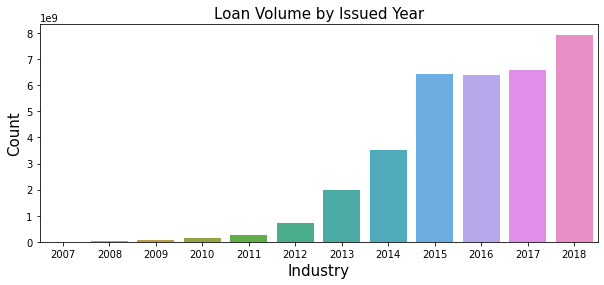

In [73]:
plt.figure(figsize=(10,4))

g = sns.barplot(x="issue_yr", 
             y= 'loan_issued_amt',
              #hue="grade",
              #palette="pastel", 
             #edgecolor=".3",
              data=df_loan,
             #sort='False',
             #order=issue_d_order,
              #hue_order = grade_order
               )

plt.title('Loan Volume by Issued Year',fontsize=15)
plt.xlabel('Industry',fontsize=15)
plt.ylabel('Count',fontsize=15)
#plt.legend(title='Grade')
plt.show(g)

**Count by issuance year**

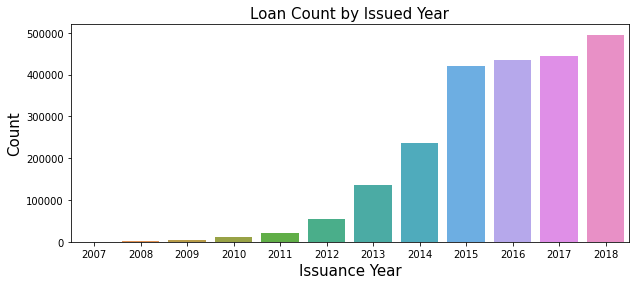

In [74]:
plt.figure(figsize=(10,4))

g = sns.barplot(x="issue_yr", 
             y= 'loan_issued_cnt',
              #hue="grade",
              #palette="pastel", 
             #edgecolor=".3",
              data=df_loan,
             #sort='False',
             #order=issue_d_order,
              #hue_order = grade_order
               )

plt.title('Loan Count by Issued Year',fontsize=15)
plt.xlabel('Issuance Year',fontsize=15)
plt.ylabel('Count',fontsize=15)
#plt.legend(title='Grade')
plt.show(g)

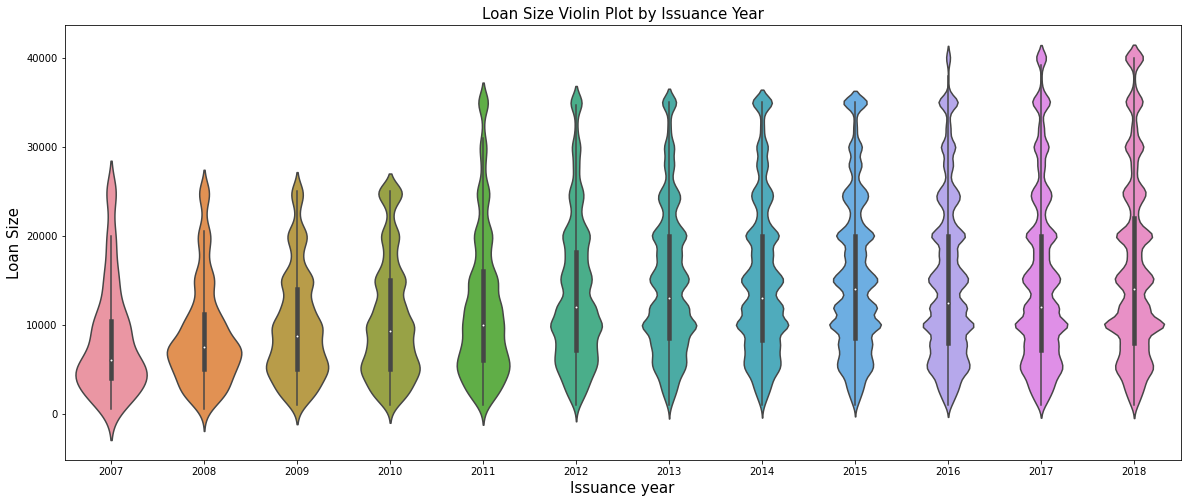

In [75]:
plt.figure(figsize=(20,8)) 
#sns.set(font_scale = 1.6,style='white')
sns.violinplot(x = accepted.issue_yr, y=accepted.loan_amnt)

plt.xlabel('Issuance year',fontsize=15) #,rotation = 45)
#plt.xticks(rotation=80)
plt.ylabel('Loan Size',fontsize=15)
plt.title('Loan Size Violin Plot by Issuance Year',fontsize=15)

plt.show()

- Volumes and counts increase by issuance year.
- Loan size increased from 2007 to and 2015, and became reletively stable in last three years.

**Loan status**

In [76]:
df_status = accepted.loan_status2.value_counts().reset_index()
df_status.columns = ['status','count']
df_status

,status,count
0,Fully Paid,1078735
1,Current,878317
2,Default,269360
3,Late,34252


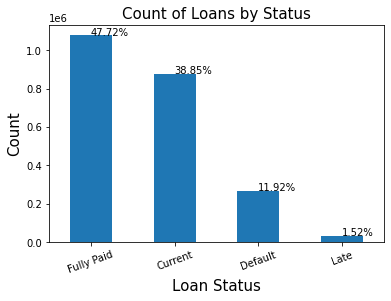

In [77]:
df_status.plot(x='status',y='count',kind='bar')

for index, value in enumerate(df_status['count']):
    plt.text(index,value, str(round((value/df_status['count'].sum())*100,2))+'%')


plt.xlabel('Loan Status',fontsize=15)#,rotation = 45)
plt.xticks(rotation=20)
plt.ylabel('Count',fontsize=15)
plt.legend().remove()
plt.title('Count of Loans by Status',fontsize=15)

plt.show()

In [78]:
df_status.loc[df_status.status=='Default',"count"] / df_status.loc[df_status.status.isin(['Fully Paid','Default']),'count'].sum()

2    0.199808
Name: count, dtype: float64

- Among the entire portfolio as of 2019, the overall default percentage of loan is about 11.92%
- For the completed loand (exl on-going, fully-paid or default), about 19.98% are default
- Potential factors correlated with default will be investgated in following sections

## 2. Term

In [79]:
accepted.term.value_counts(dropna=False)

 36 months    1609750
 60 months     650914
Name: term, dtype: int64

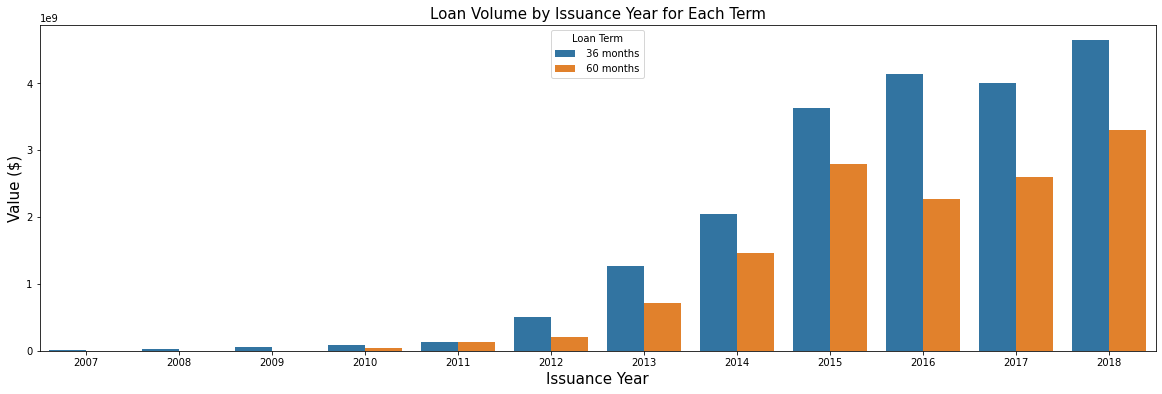

In [80]:
plt.figure(figsize=(20,6))
#grade_order = ['A','B','C','D','E','F','G']

g = sns.barplot(x="issue_yr", 
             y= 'loan_amnt',
              hue="term",
             # palette="pastel", 
             #edgecolor=".3",
              data=accepted.groupby(['issue_yr','term']).loan_amnt.sum().reset_index(),
              #hue_order = grade_order
               )

plt.xlabel('Issuance Year',fontsize=15)#,rotation = 45)
plt.xticks(rotation=0)
plt.ylabel('Value ($)',fontsize=15)
#plt.legend().remove()
plt.legend(title='Loan Term')
plt.title('Loan Volume by Issuance Year for Each Term',fontsize=15)

plt.show(g)

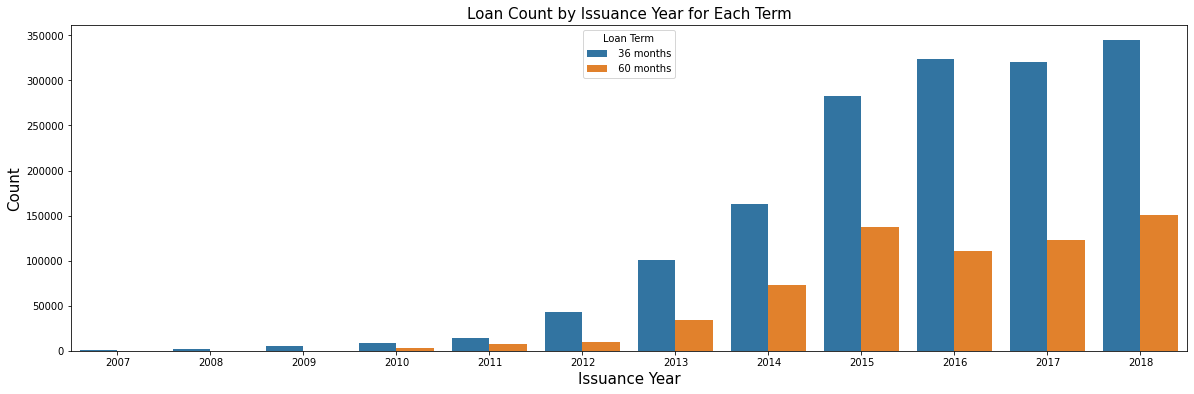

In [81]:
plt.figure(figsize=(20,6))
#grade_order = ['A','B','C','D','E','F','G']

g = sns.countplot(x="issue_yr", 
             #y= 'id',
              hue="term",
             # palette="pastel", 
             #edgecolor=".3",
              data=accepted,#accepted.groupby(['issue_yr','term']),#['id'].count().reset_index(),
              #hue_order = grade_order
               )

plt.xlabel('Issuance Year',fontsize=15)#,rotation = 45)
plt.xticks(rotation=0)
plt.ylabel('Count',fontsize=15)
#plt.legend().remove()
plt.legend(title='Loan Term')
plt.title('Loan Count by Issuance Year for Each Term',fontsize=15)

plt.show(g)

In [82]:
#accepted.groupby(['issue_yr','term']).loan_amnt.sum().reset_index()

## 3. Interest rate

In [83]:
'''df_issue_d = pd.read_csv('data/mon_year_order.csv')#, index_col=0)
issue_d_order = df_issue_d.Issue_d

temp2.sort_values("issue_d", inplace=True)'''

'df_issue_d = pd.read_csv(\'data/mon_year_order.csv\')#, index_col=0)\nissue_d_order = df_issue_d.Issue_d\n\ntemp2.sort_values("issue_d", inplace=True)'

In [84]:
import datetime

accepted['issue_dt'] = pd.to_datetime(accepted['issue_d'].apply(lambda x: datetime.datetime.strptime(x, '%b-%Y')))
#accepted['issue_dt']

temp2 = accepted.groupby(['issue_dt','grade']).int_rate.mean().reset_index()
#temp2.head(20)

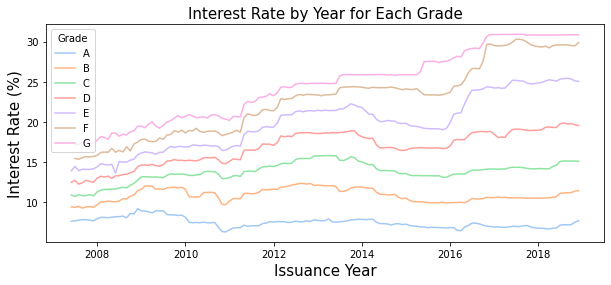

In [85]:
plt.figure(figsize=(10,4))
grade_order = ['A','B','C','D','E','F','G']

g = sns.lineplot(x="issue_dt", 
             y= 'int_rate',
              hue="grade",
              palette="pastel", 
             #edgecolor=".3",
              data=temp2,
             sort='False',
             #order=issue_d_order,
              hue_order = grade_order)

plt.title('Interest Rate by Year for Each Grade',fontsize=15)
plt.xlabel('Issuance Year',fontsize=15)
plt.ylabel('Interest Rate (%)',fontsize=15)
plt.legend(title='Grade')
plt.show(g)

## 4. Loan grade & subgrade

**Distribution - overall**

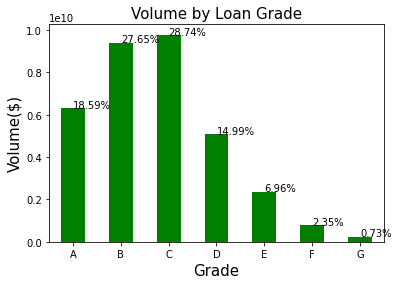

In [86]:
df_grade2 = accepted.groupby('grade').agg({'loan_amnt':'sum'}).reset_index()

df_grade2.plot(x='grade',y='loan_amnt',kind='bar',color='g')

for index, value in enumerate(df_grade2['loan_amnt']):
    plt.text(index,value, str(round((value/df_grade2['loan_amnt'].sum())*100,2))+'%')


plt.xlabel('Grade',fontsize=15)#,rotation = 45)
plt.xticks(rotation=0)
plt.ylabel('Volume($)',fontsize=15)
plt.legend().remove()
plt.title('Volume by Loan Grade',fontsize=15)

plt.show()

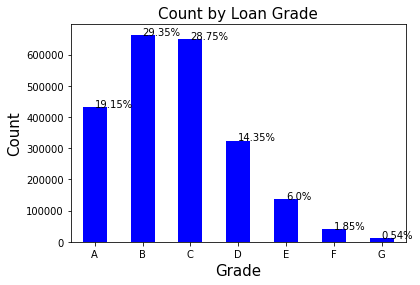

In [87]:
df_grade1 = accepted.grade.value_counts().reset_index().sort_values(by=['index'], 
                                                        ascending=True)
df_grade1.columns = ['grade','count']


df_grade1.plot(x='grade',y='count',kind='bar',color='b')

for index, value in enumerate(df_grade1['count']):
    plt.text(index,value, str(round((value/df_grade1['count'].sum())*100,2))+'%')


plt.xlabel('Grade',fontsize=15)#,rotation = 45)
plt.xticks(rotation=0)
plt.ylabel('Count',fontsize=15)
plt.legend().remove()
plt.title('Count by Loan Grade',fontsize=15)

plt.show()

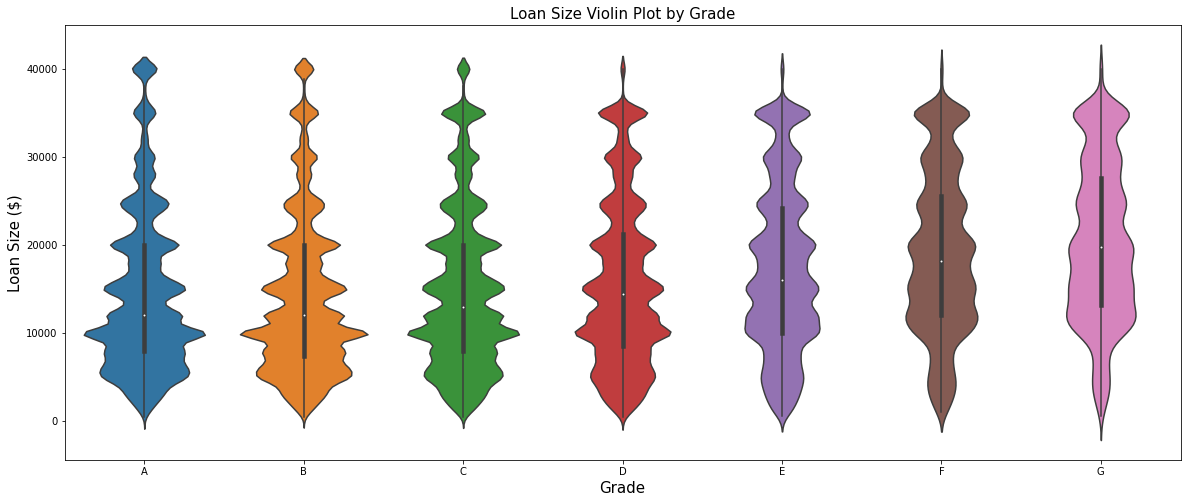

In [88]:
plt.figure(figsize=(20,8)) 
#sns.set(font_scale = 1.6,style='white')
sns.violinplot(x = accepted.grade, 
            y=accepted.loan_amnt,
            order = np.sort(accepted.grade.dropna().unique()))

plt.xlabel('Grade',rotation = 0,fontsize=15)
plt.ylabel('Loan Size ($)',fontsize=15)
plt.title('Loan Size Violin Plot by Grade',fontsize=15)

plt.show()
#sns.reset_defaults()

* Most loans are B and C grade, which is nearly 60% of the entire portfolio in terms of both volumes and counts.  
* Lower graded loans generally have larger loan amounts/sizes.

**Distribution - by issue_yr**

In [89]:
df_grade = accepted.groupby(['grade',
                             'issue_yr',
                             'loan_status2']).agg({'id':'count',
                                                   'loan_amnt':'sum'}).reset_index()

In [90]:
df_grade2

,grade,loan_amnt
0,A,6.323617e+09
1,B,9.404818e+09
2,C,9.775551e+09
3,D,5.097344e+09
4,E,2.367318e+09
5,F,7.994102e+08
6,G,2.480324e+08


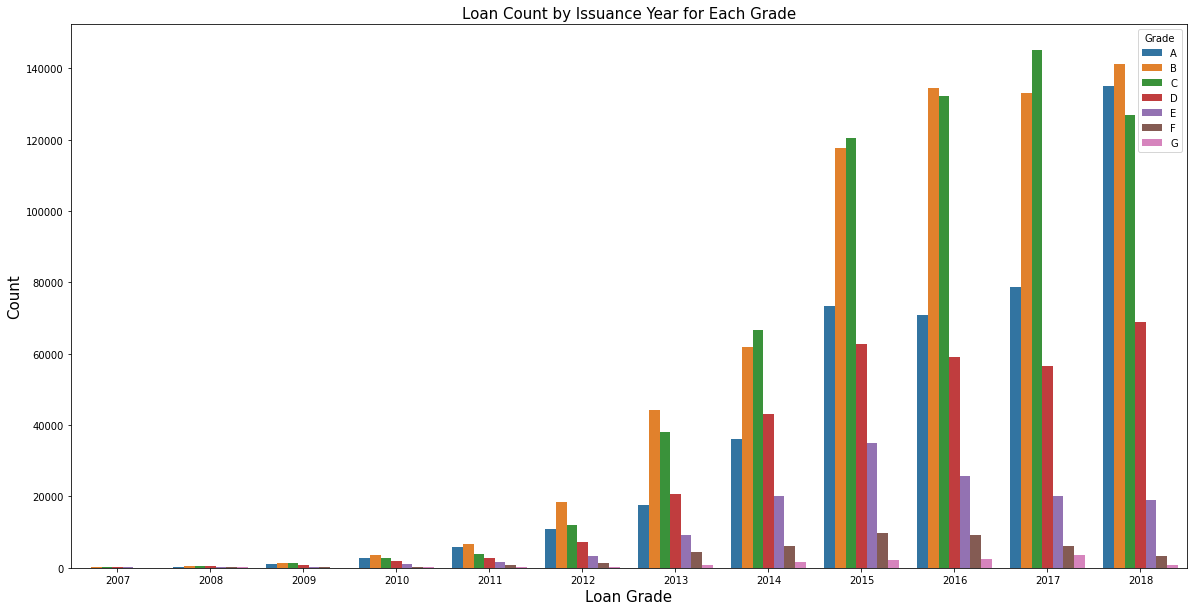

In [91]:
plt.figure(figsize=(20,10))
grade_order = ['A','B','C','D','E','F','G']

g = sns.barplot(x="issue_yr", 
             y= 'id',
              hue="grade",
             # palette="pastel", 
             #edgecolor=".3",
              data=df_grade.groupby(['grade','issue_yr'])['id'].sum().reset_index(),
              hue_order = grade_order)

plt.xlabel('Loan Grade',fontsize=15)#,rotation = 45)
plt.xticks(rotation=0)
plt.ylabel('Count',fontsize=15)
#plt.legend().remove()
plt.legend(title='Grade')
plt.title('Loan Count by Issuance Year for Each Grade',fontsize=15)

plt.show(g)

In [92]:
df_grade3 = accepted.groupby(['issue_yr',
                             'grade']).agg({'id':'count',
                                            'loan_amnt':'sum'}).reset_index()

**Default by grade**

Overall

In [93]:
'''#d_grade = accepted.groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_grade = accepted[accepted.loan_status2.isin(['Fully Paid','Default'])].groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_grade.columns = ['grade','loan_status2','count','amount']
d_grade['count_pct'] = d_grade.groupby(['grade'])['count'].apply(lambda x: x*100/x.sum())
d_grade'''

"#d_grade = accepted.groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()\nd_grade = accepted[accepted.loan_status2.isin(['Fully Paid','Default'])].groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()\nd_grade.columns = ['grade','loan_status2','count','amount']\nd_grade['count_pct'] = d_grade.groupby(['grade'])['count'].apply(lambda x: x*100/x.sum())\nd_grade"

In [94]:
'''plt.figure(figsize=(10,6))
#grade_order = ['A','B','C','D','E','F','G']
status_order = ['Fully Paid','Default']

g = sns.barplot(x="grade", 
             y= 'count_pct',
              hue="loan_status2",
              #palette="pastel", 
             #edgecolor=".3",
              data=d_grade,
             #sort='False',
             #order=issue_d_order,
              hue_order = status_order)

plt.xlabel('Loan Grade',fontsize=15)#,rotation = 45)
#plt.xticks(rotation=20)
plt.ylabel('Count (%)',fontsize=15)
plt.legend(title='Loan Status')
#plt.legend().remove()
plt.title('Count of Completed Loans by Status',fontsize=15)

plt.show(g)'''

'plt.figure(figsize=(10,6))\n#grade_order = [\'A\',\'B\',\'C\',\'D\',\'E\',\'F\',\'G\']\nstatus_order = [\'Fully Paid\',\'Default\']\n\ng = sns.barplot(x="grade", \n             y= \'count_pct\',\n              hue="loan_status2",\n              #palette="pastel", \n             #edgecolor=".3",\n              data=d_grade,\n             #sort=\'False\',\n             #order=issue_d_order,\n              hue_order = status_order)\n\nplt.xlabel(\'Loan Grade\',fontsize=15)#,rotation = 45)\n#plt.xticks(rotation=20)\nplt.ylabel(\'Count (%)\',fontsize=15)\nplt.legend(title=\'Loan Status\')\n#plt.legend().remove()\nplt.title(\'Count of Completed Loans by Status\',fontsize=15)\n\nplt.show(g)'

Default by year for each grade

In [95]:
df_grade.columns = df_grade.columns.str.replace('id', 'count')

#df_default_grade

df_grade['count_pct'] = df_grade.groupby(['grade','issue_yr'])['count'].apply(lambda x: x*100/x.sum())
df_grade['total_loan_cnt'] = df_grade.groupby(['grade','issue_yr'])['count'].apply(lambda x: (x/x)*x.sum())
df_grade['total_loan_amt'] = df_grade.groupby(['grade','issue_yr'])['loan_amnt'].apply(lambda x: (x/x)*x.sum())

#df_loan.columns = ['issue_yr', 'loan_issued_vol', 'loan_issued_cnt']


#df['perc'] = df.groupby('age')['count'].apply(lambda x: x*100/x.sum())

In [96]:
#df_grade

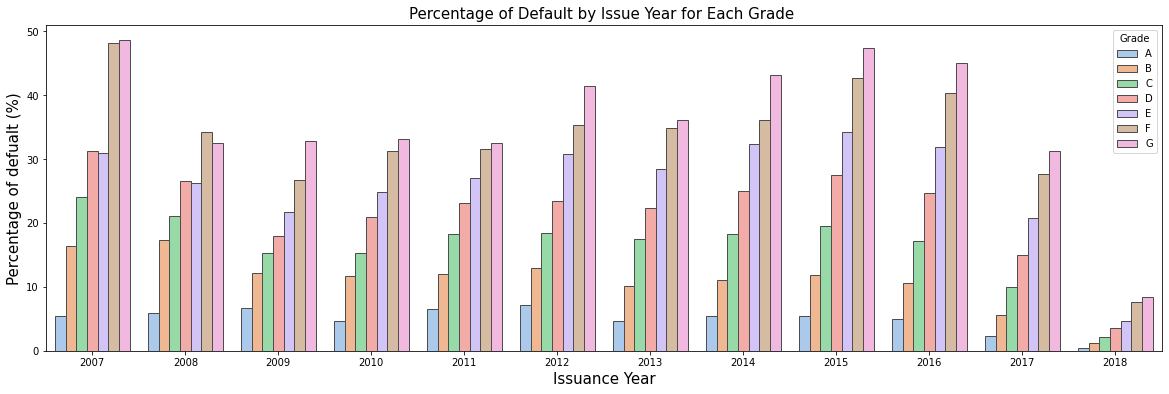

In [97]:
plt.figure(figsize=(20,6))
grade_order = ['A','B','C','D','E','F','G']

g = sns.barplot(x="issue_yr", 
             y= 'count_pct',
              hue="grade",
              palette="pastel", 
             edgecolor=".3",
              data=df_grade.loc[df_grade.loan_status2 == 'Default'],
             #sort='False',
             #order=issue_d_order,
              hue_order = grade_order)
              

plt.xlabel('Issuance Year',fontsize=15)#,rotation = 45)
#plt.xticks(rotation=0)
plt.ylabel('Percentage of defualt (%)',fontsize=15)
#plt.legend().remove()
plt.legend(title='Grade')
plt.title('Percentage of Default by Issue Year for Each Grade ',fontsize=15)

plt.show(g)

## 5. Purpose

In [98]:
'''purpose_order = accepted.purpose.unique()

plt.figure(figsize=(20,10))

sns.countplot(x="purpose",
              hue="grade",
              palette="pastel", 
              edgecolor=".3",
              data=accepted,
              hue_order = grade_order).\
              set(title='Loan grade by purpose',xlabel='Loan Purpose',ylabel='Count')


purpose_order = accepted.purpose.unique()

plt.figure(figsize=(20,10))

sns.countplot(x="grade",
              hue="purpose",
              palette="pastel", 
              edgecolor=".3",
              data=accepted,
              order = np.sort(accepted.grade.dropna().unique()),
              hue_order = purpose_order).\
              set(title='Loan grade by purpose',xlabel='Loan Purpose',ylabel='Count')'''

'purpose_order = accepted.purpose.unique()\n\nplt.figure(figsize=(20,10))\n\nsns.countplot(x="purpose",\n              hue="grade",\n              palette="pastel", \n              edgecolor=".3",\n              data=accepted,\n              hue_order = grade_order).              set(title=\'Loan grade by purpose\',xlabel=\'Loan Purpose\',ylabel=\'Count\')\n\n\npurpose_order = accepted.purpose.unique()\n\nplt.figure(figsize=(20,10))\n\nsns.countplot(x="grade",\n              hue="purpose",\n              palette="pastel", \n              edgecolor=".3",\n              data=accepted,\n              order = np.sort(accepted.grade.dropna().unique()),\n              hue_order = purpose_order).              set(title=\'Loan grade by purpose\',xlabel=\'Loan Purpose\',ylabel=\'Count\')'

In [99]:
'''import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt
%matplotlib inline
#credit https://matplotlib.org/devdocs/gallery/pie_and_polar_charts/pie_demo2.html#sphx-glr-gallery-pie-and-polar-charts-pie-demo2-py

source_labels = pie_sources.FoodCode.sort_values().index
source_counts = pie_sources.FoodCode.sort_values()

flavor_labels = pie_flavors.Source.sort_values().index
flavor_counts = pie_flavors.Source.sort_values()

# Make square figures and axes
plt.figure(1, figsize=(20,10))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]


plt.subplot(the_grid[0, 1], aspect=1, title='Source of Pies')

source_pie = plt.pie(source_counts, labels=source_labels, autopct='%1.1f%%', shadow=True, colors=colors)


plt.subplot(the_grid[0, 0], aspect=1, title='Selected Flavors of Pies')

flavor_pie = plt.pie(flavor_counts,labels=flavor_labels, autopct='%.0f%%', shadow=True, colors=colors)

plt.suptitle('Pie Consumption Patterns in the United States', fontsize=16)


plt.show()
'''

"import matplotlib.ticker as ticker\nimport matplotlib.cm as cm\nimport matplotlib as mpl\nfrom matplotlib.gridspec import GridSpec\n\nimport matplotlib.pyplot as plt\n%matplotlib inline\n#credit https://matplotlib.org/devdocs/gallery/pie_and_polar_charts/pie_demo2.html#sphx-glr-gallery-pie-and-polar-charts-pie-demo2-py\n\nsource_labels = pie_sources.FoodCode.sort_values().index\nsource_counts = pie_sources.FoodCode.sort_values()\n\nflavor_labels = pie_flavors.Source.sort_values().index\nflavor_counts = pie_flavors.Source.sort_values()\n\n# Make square figures and axes\nplt.figure(1, figsize=(20,10))\nthe_grid = GridSpec(2, 2)\n\n\ncmap = plt.get_cmap('Spectral')\ncolors = [cmap(i) for i in np.linspace(0, 1, 8)]\n\n\nplt.subplot(the_grid[0, 1], aspect=1, title='Source of Pies')\n\nsource_pie = plt.pie(source_counts, labels=source_labels, autopct='%1.1f%%', shadow=True, colors=colors)\n\n\nplt.subplot(the_grid[0, 0], aspect=1, title='Selected Flavors of Pies')\n\nflavor_pie = plt.pie(fl

In [100]:
df_byPurpose = accepted.groupby('purpose').agg({'loan_amnt':'sum'}).reset_index()
df_byPurpose.columns = ['Purpose','loan_size']

df_byPurpose['Percent'] = df_byPurpose.loan_size / accepted.loan_amnt.sum()
df_byPurpose

,Purpose,loan_size,Percent
0,car,2.255714e+08,0.006631
1,credit_card,7.919856e+09,0.232827
2,debt_consolidation,2.040347e+10,0.599818
3,educational,2.804600e+06,0.000082
4,home_improvement,2.206625e+09,0.064870
5,house,2.219906e+08,0.006526
6,major_purchase,6.397652e+08,0.018808
7,medical,2.604266e+08,0.007656
8,moving,1.292437e+08,0.003799
9,other,1.461458e+09,0.042964


In [363]:
import plotly.express as px


#plt.figure(figsize=(10,2))
fig = px.pie(df_byPurpose, 
#fig = px.pie(df_byPurpose, 
             values='Percent', 
             names='Purpose', 
             title='Volumn by Purpose'
            )
fig.show()


# fig1 = px.pie(df1, names = "Genre", title = "Distribution of Video Game Genres", color_discrete_sequence=px.colors.qualitative.Set3)
# fig1.show()

In [102]:
purpose_order = accepted.groupby(['purpose']).loan_amnt.mean().reset_index().sort_values('loan_amnt',ascending=False).purpose
purpose_order

11        small_business
2     debt_consolidation
5                  house
1            credit_card
4       home_improvement
6         major_purchase
10      renewable_energy
9                  other
13               wedding
7                medical
0                    car
8                 moving
3            educational
12              vacation
Name: purpose, dtype: object

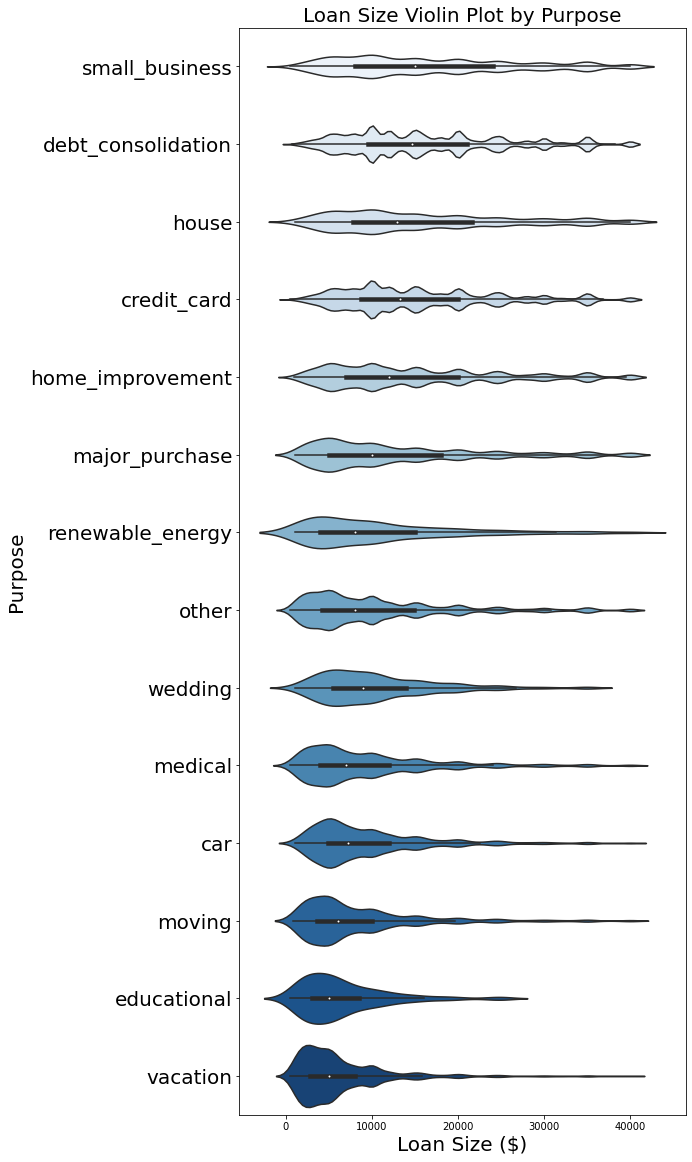

In [103]:
plt.figure(figsize=(8,20)) 
#sns.set(font_scale = 1.6,style='white')
sns.violinplot(y = accepted.purpose, 
            x=accepted.loan_amnt,
               #color = 'gray'
            order = purpose_order,#dropna().unique())
             palette="Blues")
             # palette="Pastel1")

plt.ylabel('Purpose',fontsize=20)#rotation = 45)
plt.yticks(rotation=0,fontsize=20)
plt.xlabel('Loan Size ($)',fontsize=20)
plt.title('Loan Size Violin Plot by Purpose',fontsize=20)

plt.show()
#sns.reset_defaults()

- In terms of loan size, loan sizes for small business and debt consolidations are higher； vacation and educational lower

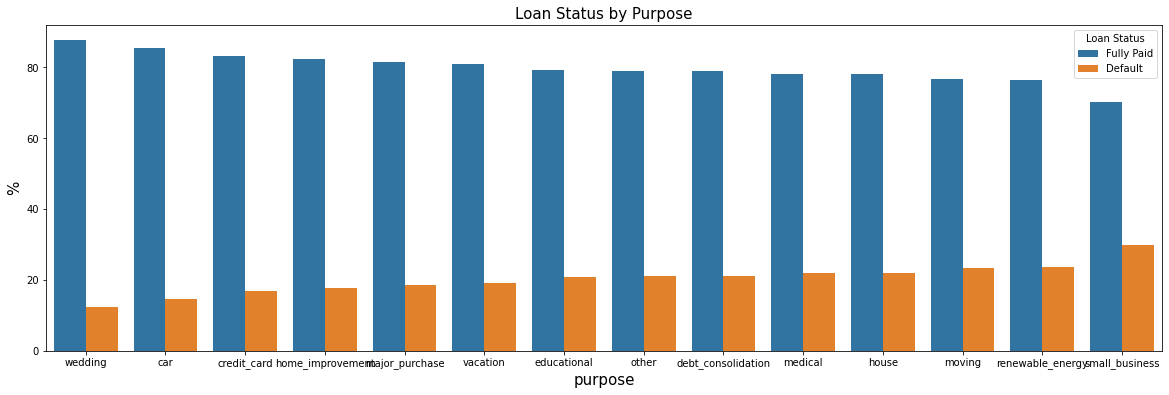

In [104]:
default_by_feature('purpose','purpose','large','y',accepted)

* Default rates varies across purpose. Small businessed is the highest. Debt consolidation, houses, moving and rewbale enegry are relatively high.wedding is the lowest.

## 6. Income

In [105]:
accepted[['income']].describe()

,income
count,2.260664e+06
mean,8.138379e+04
std,1.137092e+05
min,1.896000e+03
25%,4.800000e+04
50%,6.850000e+04
75%,9.800000e+04
max,1.100000e+08


<AxesSubplot: >

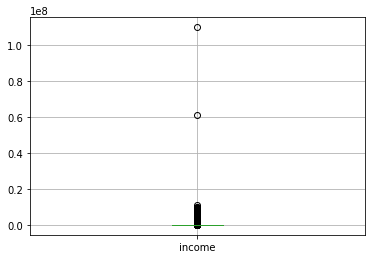

In [106]:
accepted[['income']].boxplot()

In [107]:
accepted.income.sort_values(ascending=False).head(5)

601128     110000000.0
1673140     61000000.0
539807      10999200.0
1597151      9930475.0
1413812      9757200.0
Name: income, dtype: float64

In [108]:
accepted[accepted.income == 61000000]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,loan_status2,issue_yr,roi,sub_grade2,FICO1,FICO2,FICO,dti_inuse,income,issue_dt
1673140,101074293,NaN,10000.0,10000.0,10000.0,36 months,11.44,329.48,B,B4,...,Current,2017,-0.2082,9,692.0,692.0,692.0,0.01,61000000.0,2017-03-01


In [109]:
accepted.shape

(2260664, 161)

In [110]:
income_index = accepted[ accepted.income >10000000 ].index
accepted.drop(income_index , inplace=True)
accepted.shape

(2260661, 161)

In [111]:
accepted[['income']].describe()

,income
count,2.260661e+06
mean,8.130340e+04
std,7.675271e+04
min,1.896000e+03
25%,4.800000e+04
50%,6.850000e+04
75%,9.800000e+04
max,9.930475e+06


<AxesSubplot: >

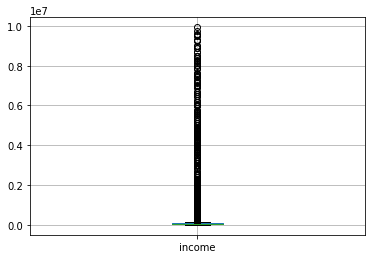

In [112]:
accepted[['income']].boxplot()

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



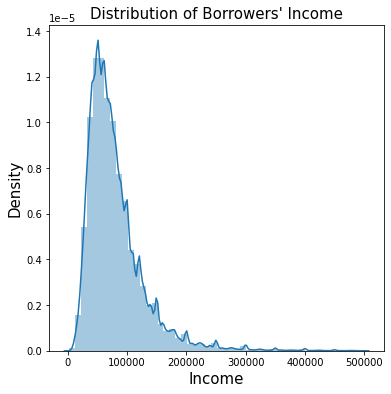

In [113]:
plt.figure(figsize=(6,6))
sns.distplot(accepted.loc[accepted['income'] < 500000,'income'] )



plt.xlabel('Income',fontsize=15)#,rotation = 45)
#plt.xticks(rotation=20)
plt.ylabel('Density',fontsize=15)
#plt.legend(title='verification  Status')
#plt.legend().remove()
plt.title("Distribution of Borrowers' Income",fontsize=15)

#plt.show(g)
plt.show()


## 7. State

In [114]:
# # Create data set with number of loans per state

# lc.states <- data.frame(table(df$addr_state))
# names(lc.states) <- c("state","count")
# lc.states$id <- tolower(state.name[match(lc.states$state,state.abb)])
# lc.states$id[lc.states$state == "DC"] <- "district of columbia"

# lc.states[c("state","count")]


df_state1 = accepted.groupby(['addr_state']).agg({'id':'count'}).sort_values(by='id').reset_index()

In [115]:
df_state1.columns = ['State','Count']

In [116]:
#import pandas as pd 
import plotly.express as px

#df['period_begin'] = pd.to_datetime(df['period_begin']).dt.date.astype(str)
#df=df.sort_values("period_begin") # Make sure you sort the time horizon column in ascending order because this column is in random order in the raw dataset

fig = px.choropleth(df_state1,
                    locations='State', 
                    locationmode="USA-states", 
                    color='Count',
                    color_continuous_scale="Viridis_r", 
                    #colorbar = {'title' : 'Count'},
#                     color_discrete_map = {'Under 5k':'red', 
#                                           '5k-19k':'darkslategray1',
#                                           '20k-49k':'darkslategray2',
#                                           '50k-99k':'darkslategray3', 
#                                           '100k-199k':'darkslategray4',
#                                           '200k+':'darkslategray1'},
                    #colorscale = 'Reds',
                    scope="usa",
                    #animation_frame='period_begin'
                   )

#plt.title('Loan count by State',fontsize=15)


fig.show()

* California - most count
* 2nd tier - tx,ny, fl

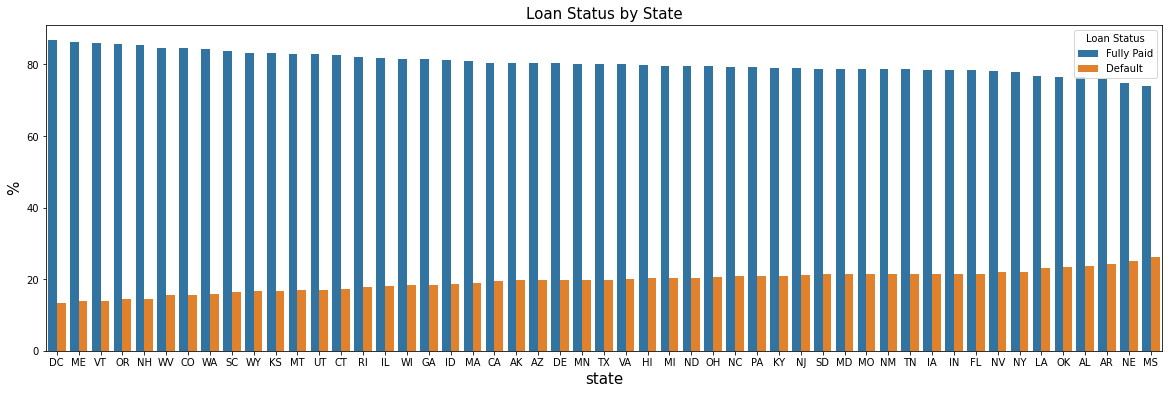

In [117]:
default_by_feature('addr_state','state','large','y',accepted)

## 8. DTI

In [118]:
accepted['dti_inuse'].describe()

count    2.260661e+06
mean     1.815509e+01
std      8.398288e+00
min     -1.000000e+00
25%      1.187000e+01
50%      1.767000e+01
75%      2.407000e+01
max      6.949000e+01
Name: dti_inuse, dtype: float64

<AxesSubplot: >

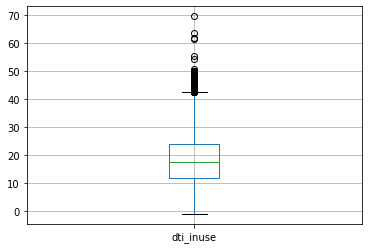

In [119]:
accepted[['dti_inuse']].boxplot()

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



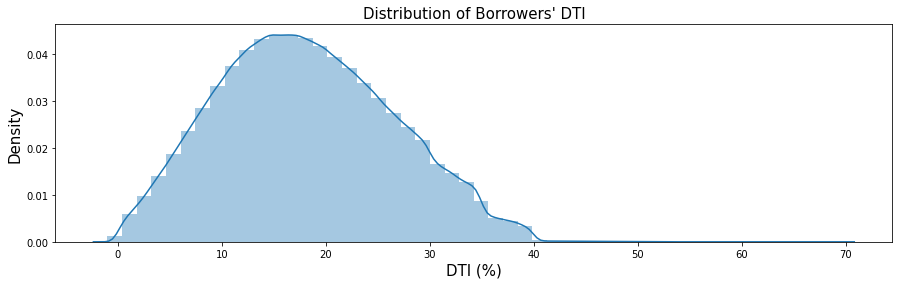

In [120]:
plt.figure(figsize=(15,4))
sns.distplot(accepted.dti_inuse)

plt.xlabel('DTI (%)',fontsize=15)#,rotation = 45)
plt.ylabel('Density',fontsize=15)
plt.title("Distribution of Borrowers' DTI",fontsize=15)

plt.show()

## 9. revol_util

In [121]:
accepted.revol_util.describe()

count    2.258863e+06
mean     5.033769e+01
std      2.471308e+01
min      0.000000e+00
25%      3.150000e+01
50%      5.030000e+01
75%      6.940000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

<AxesSubplot: >

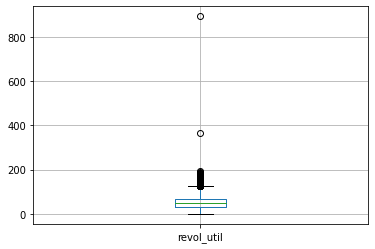

In [122]:
accepted[['revol_util']].boxplot()

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



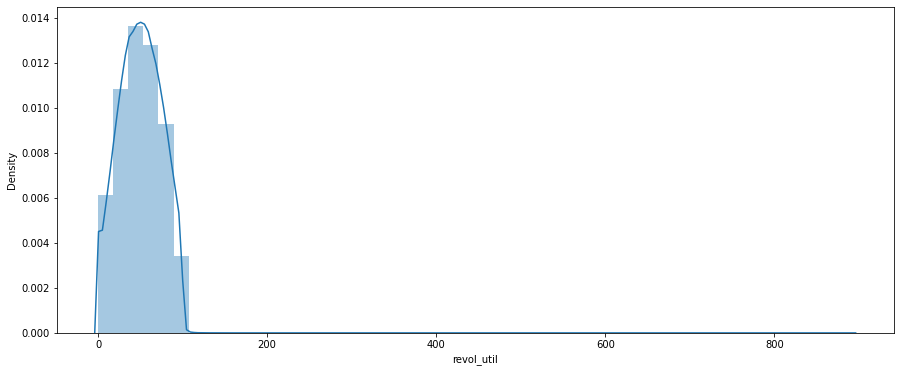

In [123]:
plt.figure(figsize=(15,6))
sns.distplot(accepted.revol_util)
plt.show()

In [124]:
accepted['util_bucket'] = 'NA'
#df_state1.loc[df_state1.id,'bucket'] = "Under 5k"


accepted.loc[accepted.revol_util < 50,'util_bucket'] = "Under 50%"
accepted.loc[(accepted.revol_util >= 50) & (accepted.revol_util < 90),'util_bucket'] = "50-90%"
accepted.loc[(accepted.revol_util >= 90) & (accepted.revol_util < 100),'util_bucket'] = "90-100%"
accepted.loc[(accepted.revol_util >= 100) & (accepted.revol_util < 200),'util_bucket'] = "100-200%"
accepted.loc[(accepted.revol_util >= 200) & (accepted.revol_util < 300),'util_bucket'] = "200-300%"
accepted.loc[(accepted.revol_util >= 300) & (accepted.revol_util < 400),'util_bucket'] = "300-400%"
accepted.loc[(accepted.revol_util >= 400),'bucket'] = ">400%"


In [125]:
accepted.util_bucket.value_counts()

Under 50%    1118775
50-90%       1011373
90-100%       120486
100-200%        8227
NA              1799
300-400%           1
Name: util_bucket, dtype: int64

In [126]:
accepted.revol_util.mean()

50.33769240099881

In [127]:
accepted.revol_util.median()

50.3

In [128]:
accepted.loc[accepted.util_bucket=='NA','util_bucket'] = "50-90%"

## 10. FICO

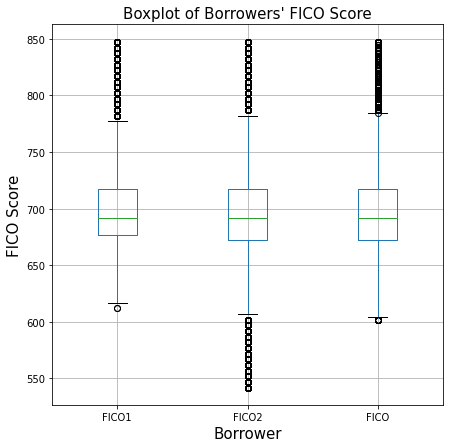

In [129]:
plt.figure(figsize=(7,7))
accepted[['FICO1','FICO2','FICO']].boxplot()
plt.xlabel('Borrower',fontsize=15)#,rotation = 45)
#plt.xticks(rotation=20)
plt.ylabel('FICO Score',fontsize=15)
#plt.legend(title='verification  Status')
#plt.legend().remove()
plt.title("Boxplot of Borrowers' FICO Score",fontsize=15)

#plt.show(g)
plt.show()

In [130]:
accepted[['FICO1','FICO2','FICO']].describe()

,FICO1,FICO2,FICO
count,2.260661e+06,2.260661e+06,2.260661e+06
mean,7.005882e+02,6.984684e+02,6.995283e+02
std,3.301064e+01,3.363775e+01,3.261105e+01
min,6.120000e+02,5.420000e+02,6.020000e+02
25%,6.770000e+02,6.720000e+02,6.720000e+02
50%,6.920000e+02,6.920000e+02,6.920000e+02
75%,7.170000e+02,7.170000e+02,7.170000e+02
max,8.475000e+02,8.475000e+02,8.475000e+02


* analyze range ...

## 11. length of employment

In [131]:
accepted.emp_length.value_counts(dropna=False)

10+ years    748003
2 years      203677
< 1 year     189984
3 years      180753
1 year       148402
NaN          146907
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: emp_length, dtype: int64

In [132]:
accepted.loc[accepted.loan_status2.isin(['Fully Paid','Default'])].loan_status2#.groupby(['emp_length','loan_status2'])

0          Fully Paid
1          Fully Paid
2          Fully Paid
4          Fully Paid
5          Fully Paid
              ...    
2260688    Fully Paid
2260690    Fully Paid
2260691       Default
2260692    Fully Paid
2260697       Default
Name: loan_status2, Length: 1348094, dtype: object

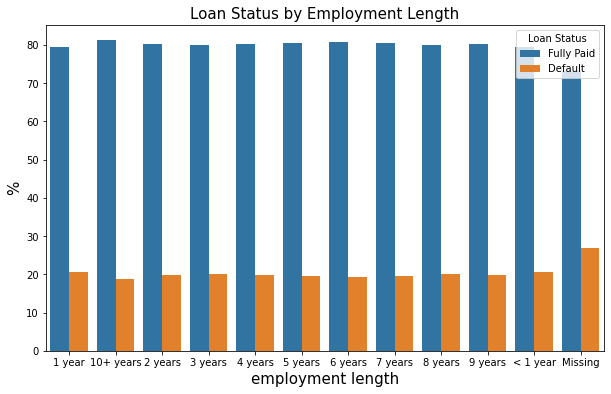

In [133]:
default_by_feature('emp_length','employment length','small','n',accepted)

In [134]:
# treat emp_length as No_Employment_Flag

### New Feature
accepted['emp_len_provided'] = 1 
accepted.loc[accepted['emp_length'].isna(),'emp_len_provided'] = 0
accepted['emp_len_provided'].value_counts(dropna=False)

1    2113754
0     146907
Name: emp_len_provided, dtype: int64

## 12. Others

**Verified**

In [135]:
accepted.verification_status.value_counts(dropna=False)

Source Verified    886229
Not Verified       744802
Verified           629630
Name: verification_status, dtype: int64

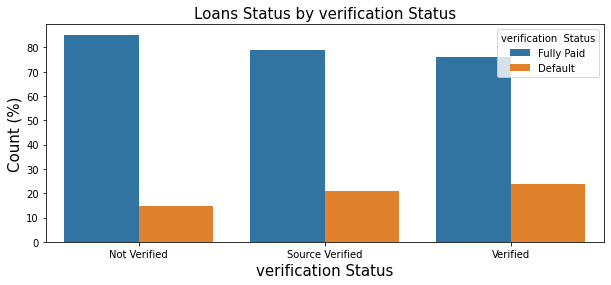

In [136]:
#d_grade = accepted.groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_vrfd = accepted[accepted.loan_status2.isin(['Fully Paid','Default'])].groupby(['verification_status','loan_status2'],dropna=False).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_vrfd.columns = ['verification_status','loan_status2','count','amount']
d_vrfd['count_pct'] = d_vrfd.groupby(['verification_status'],dropna=False)['count'].apply(lambda x: x*100/x.sum())
#d_vrfd
d_vrfd["verification_status"] = d_vrfd['verification_status'].fillna('Missing')


plt.figure(figsize=(10,4))
#grade_order = ['A','B','C','D','E','F','G']
status_order = ['Fully Paid','Default']

g = sns.barplot(x="verification_status", 
             y= 'count_pct',
              hue="loan_status2",
              #palette="pastel", 
             #edgecolor=".3",
              data=d_vrfd,
             #sort='False',
             #order=issue_d_order,
              hue_order = status_order)

plt.xlabel('verification Status',fontsize=15)#,rotation = 45)
#plt.xticks(rotation=20)
plt.ylabel('Count (%)',fontsize=15)
plt.legend(title='verification  Status')
#plt.legend().remove()
plt.title('Loans Status by verification Status',fontsize=15)

plt.show(g)

In [137]:
accepted.verification_status_joint.value_counts(dropna=False)

NaN                2144931
Not Verified         57403
Source Verified      34827
Verified             23500
Name: verification_status_joint, dtype: int64

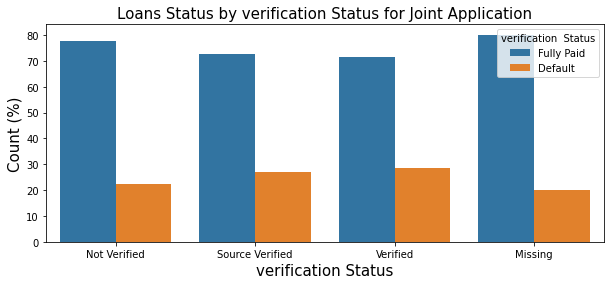

In [138]:
#d_grade = accepted.groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_vrfd = accepted[accepted.loan_status2.isin(['Fully Paid','Default'])].groupby(['verification_status_joint','loan_status2'],dropna=False).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_vrfd.columns = ['verification_status_joint','loan_status2','count','amount']
d_vrfd['count_pct'] = d_vrfd.groupby(['verification_status_joint'],dropna=False)['count'].apply(lambda x: x*100/x.sum())
#d_vrfd
d_vrfd["verification_status_joint"] = d_vrfd['verification_status_joint'].fillna('Missing')



plt.figure(figsize=(10,4))
#grade_order = ['A','B','C','D','E','F','G']
status_order = ['Fully Paid','Default']

g = sns.barplot(x="verification_status_joint", 
             y= 'count_pct',
              hue="loan_status2",
              #palette="pastel", 
             #edgecolor=".3",
              data=d_vrfd,
             #sort='False',
             #order=issue_d_order,
              hue_order = status_order)

plt.xlabel('verification Status',fontsize=15)#,rotation = 45)
#plt.xticks(rotation=20)
plt.ylabel('Count (%)',fontsize=15)
plt.legend(title='verification  Status')
#plt.legend().remove()
plt.title('Loans Status by verification Status for Joint Application',fontsize=15)

plt.show(g)

* Verification is not really helpful for both individual and joint applications.

**Homeownership**

[Text(0.5, 1.0, 'Count by Home Ownership'),
 Text(0.5, 0, 'Loan Purpose'),
 Text(0, 0.5, 'Count')]

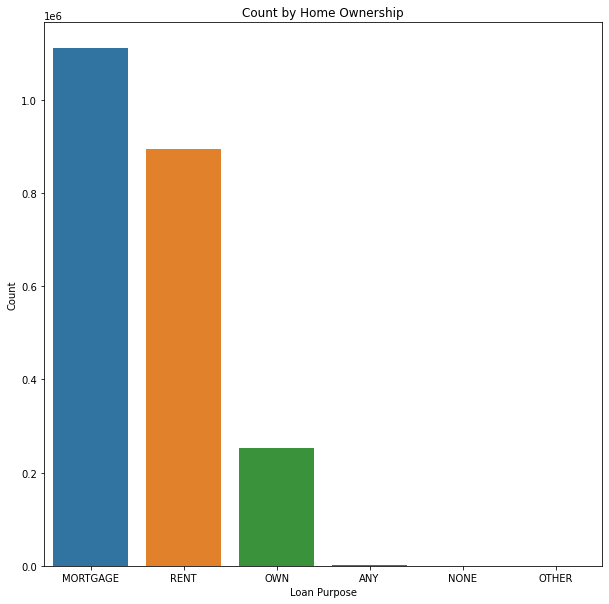

In [139]:
purpose_order = accepted.purpose.unique()

plt.figure(figsize=(10,10))

sns.countplot(x="home_ownership",
              #hue="grade",
              #palette="pastel", 
              #edgecolor=".3",
              data=accepted,
             # hue_order = grade_order
             ).\
              set(title='Count by Home Ownership',xlabel='Loan Purpose',ylabel='Count')

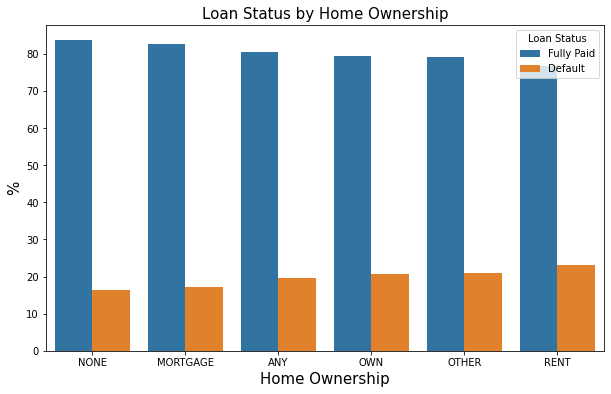

In [140]:
default_by_feature('home_ownership','Home Ownership','small','y',accepted)

In [141]:
'''#d_grade = accepted.groupby(['grade','loan_status2']).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_home = accepted[accepted.loan_status2.isin(['Fully Paid','Default'])].groupby(['home_ownership','loan_status2'],dropna=False).agg({'id':'count','funded_amnt':'sum'}).reset_index()
d_home.columns = ['home_ownership','loan_status2','count','amount']
d_home['count_pct'] = d_home.groupby(['home_ownership'],dropna=False)['count'].apply(lambda x: x*100/x.sum())
#d_home
d_home["home_ownership"] = d_home['home_ownership'].fillna('Missing')



plt.figure(figsize=(20,6))
#grade_order = ['A','B','C','D','E','F','G']
status_order = ['Fully Paid','Default']

g = sns.barplot(x="home_ownership", 
             y= 'count_pct',
              hue="loan_status2",
              #palette="pastel", 
             #edgecolor=".3",
              data=d_home,
             #sort='False',
             #order=issue_d_order,
              hue_order = status_order)

plt.xlabel('Loan Grade',fontsize=15)#,rotation = 45)
plt.xticks(rotation=20)
plt.ylabel('Count (%)',fontsize=15)
plt.legend(title='Loan Status')
#plt.legend().remove()
plt.title('Count of Completed Loans by Status',fontsize=15)

plt.show(g)'''

'#d_grade = accepted.groupby([\'grade\',\'loan_status2\']).agg({\'id\':\'count\',\'funded_amnt\':\'sum\'}).reset_index()\nd_home = accepted[accepted.loan_status2.isin([\'Fully Paid\',\'Default\'])].groupby([\'home_ownership\',\'loan_status2\'],dropna=False).agg({\'id\':\'count\',\'funded_amnt\':\'sum\'}).reset_index()\nd_home.columns = [\'home_ownership\',\'loan_status2\',\'count\',\'amount\']\nd_home[\'count_pct\'] = d_home.groupby([\'home_ownership\'],dropna=False)[\'count\'].apply(lambda x: x*100/x.sum())\n#d_home\nd_home["home_ownership"] = d_home[\'home_ownership\'].fillna(\'Missing\')\n\n\n\nplt.figure(figsize=(20,6))\n#grade_order = [\'A\',\'B\',\'C\',\'D\',\'E\',\'F\',\'G\']\nstatus_order = [\'Fully Paid\',\'Default\']\n\ng = sns.barplot(x="home_ownership", \n             y= \'count_pct\',\n              hue="loan_status2",\n              #palette="pastel", \n             #edgecolor=".3",\n              data=d_home,\n             #sort=\'False\',\n             #order=issue_d_or

## Interest

In [142]:
df_roi = accepted.loc[accepted.loan_status2.isin(['Fully Paid','Default']),['term','issue_yr','grade','loan_status2','roi']]
print(df_roi.shape)
#df_roi.head()      

(1348094, 5)


In [143]:
#df_roi

df_roi = df_roi.groupby(['term','grade']).agg({'roi':'mean'}).reset_index()

df_roi['roi'] = round(df_roi['roi']*100,2)

In [144]:
df_roi['roi']

0     5.28
1     5.57
2     3.68
3     2.44
4     0.85
5     0.45
6    -9.08
7     4.63
8     3.91
9     1.69
10   -0.67
11   -1.83
12   -4.06
13   -8.45
Name: roi, dtype: float64

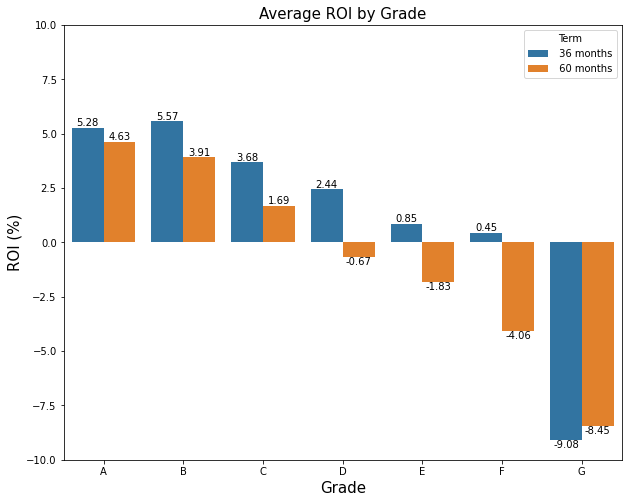

In [145]:
plt.figure(figsize=(10,8))


#grade_order = ['A','B','C','D','E','F','G']
status_order = ['Fully Paid','Default']

g = sns.barplot(x='grade', 
                y= 'roi',
                hue="term",
              #palette="pastel", 
             #edgecolor=".3",
              data=df_roi)#,
             #sort='False',
             #order=issue_d_order,
             # hue_order = status_order)

for i in g.containers:
    g.bar_label(i,)

# g.bar_label(round(g.containers[1],2))
    
plt.xlabel('Grade',fontsize=15)#,rotation = 45)
plt.ylabel('ROI (%)',fontsize=15)
plt.ylim(-10, 10)
plt.legend(title='Term')
plt.title('Average ROI by Grade',fontsize=15)




plt.show(g)

## II. Preprocessing for modeling

**Step 1 - Subset dataset for modeling: use completed loans only** (fully-paid & default)

In [146]:
df_full_cnt = accepted.loan_status2.value_counts(dropna=False).reset_index()
df_full_cnt['pct'] = df_full_cnt.loan_status2/df_full_cnt.loan_status2.sum()
df_full_cnt

,index,loan_status2,pct
0,Fully Paid,1078734,0.477176
1,Current,878315,0.388521
2,Default,269360,0.119151
3,Late,34252,0.015151


In [147]:
print(accepted.shape)
accepted = accepted[accepted.loan_status2.isin(['Fully Paid','Default'])]
print(accepted.shape)

(2260661, 164)
(1348094, 164)


**Potential variables**  
Selected based on combinantion of:
1. analysis in previous analysis (EDA)
2. industry experience

In [148]:
loan_feature = [
#====== loan ======
'grade',
'term',
'funded_amnt',
'int_rate',
'purpose',
#====== income ====== (by 'application_type')
'income', #--- A ---'annual_inc', / 'annual_inc_joint',
#====== debt ======
'dti_inuse', #--- B ---'dti', / 'dti_joint',
'util_bucket', #--- E.---'revol_util',
#====== other ====== (histotical performance & multiplfaform)
'FICO', #--- C ---'fico_range_high'/ 'fico_range_low'/'sec_app_fico_range_low' / 'sec_app_fico_range_high' 
'emp_len_provided' , #--- D --- 'emp_length'

'inq_last_6m', #  ---(1)--- 'inq_last_6mths', / 'sec_app_inq_last_6mths' 
'acc_open_past_24mths',
'open_act_il',

### selective historical past-due related measures
'pct_tl_nvr_dlq',
'mths_since_last_delinq',
# ---(2)---'mths_since_last_major_derog', / 'sec_app_mths_since_last_major_derog' 
'num_accts_ever_120_pd',
'num_tl_30dpd',
'acc_now_delinq',
'chargeoff_within_12m', # ---(3)--- 'chargeoff_within_12_mths', / 'sec_app_chargeoff_within_12_mths' 
'collections_12m', # ---(4)--- 'collections_12_mths_ex_med', / 'sec_app_collections_12_mths_ex_med'
'pub_rec',
'pub_rec_bankruptcies']


macroecon = [
'cpi',
'gdp_growth',
'umemployment'
]

**Step 2 - feature processing**  

**2.1: handle variables with individual and joint features**

**### 1.** 'inq_last_6mths', // sec_app_inq_last_6mths 

In [149]:
accepted[['inq_last_6mths', 'sec_app_inq_last_6mths' ]].isna().sum()

inq_last_6mths                 26
sec_app_inq_last_6mths    1329458
dtype: int64

In [150]:
### New features - inq_last_6m 
# take average for the join:
accepted['inq_last_6m'] = accepted[['inq_last_6mths','sec_app_inq_last_6mths']].mean(axis=1)
accepted[['inq_last_6m']].isna().sum()
#accepted.loc[~accepted['annual_inc_joint'].isna(),'income'] = accepted.loc[~accepted['annual_inc_joint'].isna(),'annual_inc_joint']

inq_last_6m    26
dtype: int64

In [151]:
#accepted.loc[accepted.inq_last_6m.isna(),'loan_status2'].value_counts()

In [152]:
### removed 30 record
print(accepted.shape)
income_index = accepted[accepted['inq_last_6m'].isna()].index
print(len(income_index))
accepted.drop(income_index , inplace=True)
print(accepted.shape)

#accepted = acceped[~accepted.ni]

(1348094, 165)
26
(1348068, 165)


**### 2.** 'mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog '

In [153]:
accepted[['mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog']].isna().sum()

mths_since_last_major_derog             994312
sec_app_mths_since_last_major_derog    1341419
dtype: int64

In [154]:
accepted[['mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog']].describe()

,mths_since_last_major_derog,sec_app_mths_since_last_major_derog
count,353756.000000,6649.000000
mean,43.701232,36.345315
std,21.378543,23.983558
min,0.000000,0.000000
25%,27.000000,15.000000
50%,44.000000,35.000000
75%,61.000000,56.000000
max,226.000000,132.000000


In [155]:
accepted[accepted.mths_since_last_major_derog==0].shape

(262, 165)

In [156]:
### New feature - major_derog
# take average:
accepted['major_derog'] = 1
accepted.loc[accepted.mths_since_last_major_derog.isna(),'major_derog'] = 0

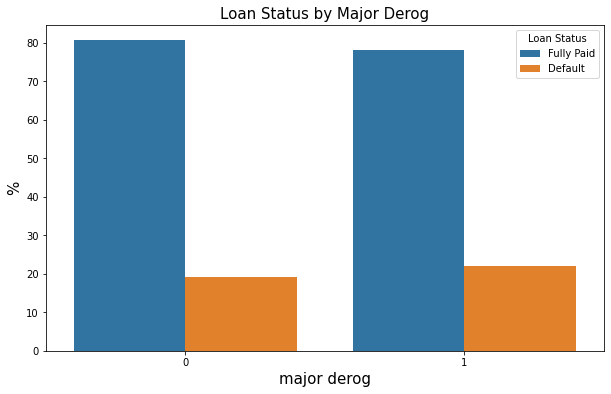

In [157]:
default_by_feature('major_derog','major derog','small','y',accepted)

In [158]:
# default has no sognificant difference between 2 groups, directly removed this feature

**### 3.** 'chargeoff_within_12_mths', // sec_app_chargeoff_within_12_mths 

In [159]:
accepted[['chargeoff_within_12_mths', 'sec_app_chargeoff_within_12_mths']].isna().sum()

chargeoff_within_12_mths                116
sec_app_chargeoff_within_12_mths    1329432
dtype: int64

<AxesSubplot: >

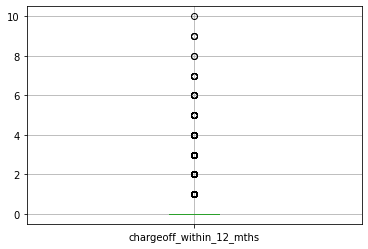

In [160]:
accepted[['chargeoff_within_12_mths']].boxplot()

In [161]:
### New feature - chargeoff_within_12m
accepted['chargeoff_within_12m'] = accepted[['chargeoff_within_12_mths',
                                             'sec_app_chargeoff_within_12_mths']].mean(axis=1)
accepted['chargeoff_within_12m'].isna().sum()

116

In [162]:
accepted.loc[accepted.chargeoff_within_12m.isna()].loan_status2.value_counts()

Fully Paid    91
Default       25
Name: loan_status2, dtype: int64

In [163]:
accepted.loc[accepted.chargeoff_within_12m.isna()].application_type.value_counts()

Individual    116
Name: application_type, dtype: int64

In [164]:
accepted[['chargeoff_within_12_mths','sec_app_chargeoff_within_12_mths','chargeoff_within_12m']].describe()

,chargeoff_within_12_mths,sec_app_chargeoff_within_12_mths,chargeoff_within_12m
count,1.347952e+06,18636.000000,1.347952e+06
mean,9.044832e-03,0.056825,9.393510e-03
std,1.096133e-01,0.463119,1.127472e-01
min,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000,0.000000e+00
50%,0.000000e+00,0.000000,0.000000e+00
75%,0.000000e+00,0.000000,0.000000e+00
max,1.000000e+01,20.000000,1.000000e+01


In [165]:
# Fill nan with individual's median (highly skewed)

In [166]:
accepted.loc[accepted.chargeoff_within_12m.isna(),'chargeoff_within_12m'] = accepted.chargeoff_within_12_mths.median()

In [167]:
accepted.chargeoff_within_12m.isna().sum()

0

**### 4.** 'collections_12_mths_ex_med', // sec_app_collections_12_mths_ex_med

In [168]:
accepted[['collections_12_mths_ex_med','sec_app_collections_12_mths_ex_med']].isna().sum()

collections_12_mths_ex_med                116
sec_app_collections_12_mths_ex_med    1329432
dtype: int64

In [169]:
accepted[['collections_12_mths_ex_med','sec_app_collections_12_mths_ex_med']].describe()

,collections_12_mths_ex_med,sec_app_collections_12_mths_ex_med
count,1.347952e+06,18636.000000
mean,1.710076e-02,0.087304
std,1.467751e-01,0.429709
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,0.000000e+00,0.000000
max,2.000000e+01,16.000000


In [170]:
### New feature - collections_12m
# - take average
accepted['collections_12m'] = accepted[['collections_12_mths_ex_med',
                                             'sec_app_collections_12_mths_ex_med']].mean(axis=1)
accepted['collections_12m'].isna().sum()

116

In [171]:
accepted.loc[accepted.collections_12m.isna()].application_type.value_counts()

Individual    116
Name: application_type, dtype: int64

In [172]:
# Fill nan with individual's mean

In [173]:
accepted[['collections_12m']].describe()

,collections_12m
count,1.347952e+06
mean,1.762006e-02
std,1.485716e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.000000e+01


In [174]:
accepted.loc[accepted.collections_12m.isna(),'collections_12m'] = accepted.collections_12_mths_ex_med.median()

In [175]:
accepted['collections_12m'].isna().sum()

0

**Step 3 - Missing values & imputation**

In [176]:
len(loan_feature)

22

In [177]:
loan_feature

['grade',
 'term',
 'funded_amnt',
 'int_rate',
 'purpose',
 'income',
 'dti_inuse',
 'util_bucket',
 'FICO',
 'emp_len_provided',
 'inq_last_6m',
 'acc_open_past_24mths',
 'open_act_il',
 'pct_tl_nvr_dlq',
 'mths_since_last_delinq',
 'num_accts_ever_120_pd',
 'num_tl_30dpd',
 'acc_now_delinq',
 'chargeoff_within_12m',
 'collections_12m',
 'pub_rec',
 'pub_rec_bankruptcies']

In [178]:
feature_null = accepted[loan_feature].isna().sum().reset_index()
feature_null.columns = ['feature','null_cnt']
#feature_null
feature_null = feature_null[feature_null.null_cnt >0].sort_values(by='null_cnt',ascending=False)
feature_null['null_cnt_pct'] =  feature_null.null_cnt/accepted.shape[0]
feature_null

,feature,null_cnt,null_cnt_pct
12,open_act_il,810434,0.601182
14,mths_since_last_delinq,679930,0.504374
13,pct_tl_nvr_dlq,70401,0.052224
15,num_accts_ever_120_pd,70247,0.052109
16,num_tl_30dpd,70247,0.052109
11,acc_open_past_24mths,50001,0.037091
21,pub_rec_bankruptcies,1336,0.000991


In [179]:
accepted.shape
list(feature_null.feature)

['open_act_il',
 'mths_since_last_delinq',
 'pct_tl_nvr_dlq',
 'num_accts_ever_120_pd',
 'num_tl_30dpd',
 'acc_open_past_24mths',
 'pub_rec_bankruptcies']

In [180]:
accepted[list(feature_null.feature)].describe()

,open_act_il,mths_since_last_delinq,pct_tl_nvr_dlq,num_accts_ever_120_pd,num_tl_30dpd,acc_open_past_24mths,pub_rec_bankruptcies
count,537634.000000,668138.000000,1.277667e+06,1.277821e+06,1.277821e+06,1.298067e+06,1.346732e+06
mean,2.792537,34.295153,9.416471e+01,5.095651e-01,3.418319e-03,4.692898e+00,1.343630e-01
std,2.989896,21.927975,8.744031e+00,1.325576e+00,6.234695e-02,3.186910e+00,3.777972e-01
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,16.000000,9.130000e+01,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00
50%,2.000000,31.000000,9.800000e+01,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,3.000000,50.000000,1.000000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00
max,57.000000,226.000000,1.000000e+02,5.100000e+01,4.000000e+00,6.400000e+01,1.200000e+01


<AxesSubplot: >

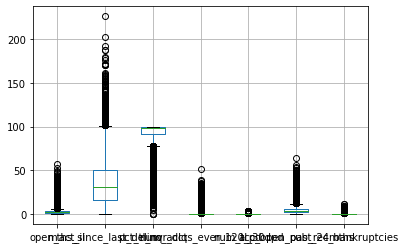

In [181]:
accepted[list(feature_null.feature)].boxplot()

**1. open_act_il**	
810434 / 60%  
Number of currently active installment tradesNumber of currently active installment trades

In [182]:
### Nan - No installment account
### 0 - No active installment account

In [183]:
accepted[accepted.open_act_il==0].shape

(60075, 168)

In [184]:
accepted.loc[accepted.open_act_il.isna(),'open_act_il'] = 0

**2. mths_since_last_delinq**  
679930 / 0.504374  
The number of months since the borrower's last delinquency

In [185]:
accepted[accepted.mths_since_last_delinq==0].shape[1]

168

In [186]:
accepted['ever_delinq'] = 1
accepted.loc[accepted.mths_since_last_delinq.isna(),'ever_delinq'] = 0
accepted.ever_delinq.value_counts()

0    679930
1    668138
Name: ever_delinq, dtype: int64

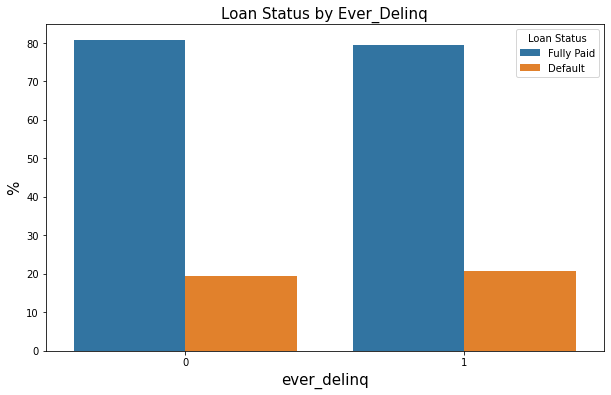

In [187]:
default_by_feature('ever_delinq','ever_delinq','small','n',accepted)

In [188]:
### No significant difference between two types, remove this feature
loan_feature.remove('mths_since_last_delinq')
len(loan_feature)

21

**3. pct_tl_nvr_dlq**	
70401	0.052224  
Percent of trades never delinquent

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



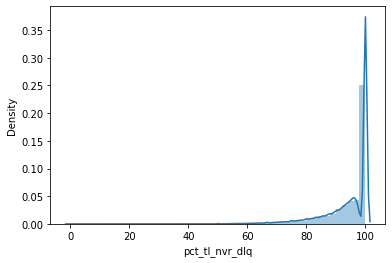

In [189]:
# SalePrice
#plt.figure(figsize=(10,6))
sns.distplot(accepted.pct_tl_nvr_dlq)
plt.show()

In [190]:
print(accepted.pct_tl_nvr_dlq.mean())
print(accepted.pct_tl_nvr_dlq.median())

94.16471271472578
98.0


In [191]:
accepted.loc[accepted.pct_tl_nvr_dlq.isna(),'pct_tl_nvr_dlq'] = accepted.pct_tl_nvr_dlq.mean()

**4. num_accts_ever_120_pd**	
70247	0.052109  
Number of accounts ever 120 or more days past due

In [192]:
### fill na by its median

In [193]:
accepted.loc[accepted.num_accts_ever_120_pd.isna(),'num_accts_ever_120_pd'] = accepted.num_accts_ever_120_pd.median()

**5. num_tl_30dpd**	
70247	0.052109  
Number of accounts currently 30 days past due (updated in past 2 months)

In [194]:
accepted['num_tl_30dpd'] = accepted.num_tl_30dpd.fillna(accepted.num_tl_30dpd.median())
accepted.num_tl_30dpd.isna().sum()

0

**6. acc_open_past_24mths**	
50001	0.037091
Number of trades opened in past 24 months.

In [195]:
print(accepted.acc_open_past_24mths.median())
print(accepted.acc_open_past_24mths.mean())

4.0
4.692897978301582


In [196]:
accepted['acc_open_past_24mths'] = accepted.acc_open_past_24mths.fillna(accepted.acc_open_past_24mths.mean())
accepted.acc_open_past_24mths.isna().sum()

0

**7. pub_rec_bankruptcies**  
1336	0.000991  
Number of public record bankruptcies

In [197]:
print(accepted.pub_rec_bankruptcies.median())
print(accepted.pub_rec_bankruptcies.mean())

0.0
0.13436303585271606


In [198]:
accepted['pub_rec_bankruptcies'] = accepted.pub_rec_bankruptcies.fillna(accepted.pub_rec_bankruptcies.mean())
accepted.pub_rec_bankruptcies.isna().sum()

0

**Step 4 - categorical variables transformation**

Starting with 21 features

In [199]:
accepted[loan_feature].dtypes

grade                     object
term                      object
funded_amnt              float64
int_rate                 float64
purpose                   object
income                   float64
dti_inuse                float64
util_bucket               object
FICO                     float64
emp_len_provided           int64
inq_last_6m              float64
acc_open_past_24mths     float64
open_act_il              float64
pct_tl_nvr_dlq           float64
num_accts_ever_120_pd    float64
num_tl_30dpd             float64
acc_now_delinq           float64
chargeoff_within_12m     float64
collections_12m          float64
pub_rec                  float64
pub_rec_bankruptcies     float64
dtype: object

In [200]:
f_num, f_cat = classify_features(loan_feature)
print(f_num)
print(f_cat)

['funded_amnt', 'int_rate', 'income', 'dti_inuse', 'FICO', 'emp_len_provided', 'inq_last_6m', 'acc_open_past_24mths', 'open_act_il', 'pct_tl_nvr_dlq', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'acc_now_delinq', 'chargeoff_within_12m', 'collections_12m', 'pub_rec', 'pub_rec_bankruptcies']
['grade', 'term', 'purpose', 'util_bucket']


***Ordinal - label encoding***

1. grade

In [201]:
accepted.grade.value_counts(dropna=False)

B    393091
C    382317
A    235182
D    201655
E     94191
F     32306
G      9326
Name: grade, dtype: int64

In [202]:
accepted['grade2'] = accepted.grade
accepted['grade2'].replace({'A':1, 
                       'B':2,
                       'C':3,
                       'D':4,
                       'E':5,
                       'F':6,
                       'G':7}, inplace=True)

In [203]:
loan_feature.remove('grade')
loan_feature.append('grade2')

2. term

In [204]:
accepted.term.value_counts(dropna=False)

 36 months    1023176
 60 months     324892
Name: term, dtype: int64

In [205]:
accepted['term2'] = accepted.term
accepted['term2'].replace({' 36 months':0, 
                            ' 60 months':1}, inplace=True)

In [206]:
loan_feature.remove('term')
loan_feature.append('term2')

3. util_bucket

In [207]:
accepted.util_bucket.value_counts()

50-90%       634719
Under 50%    631298
90-100%       76846
100-200%       5204
300-400%          1
Name: util_bucket, dtype: int64

In [208]:
accepted['util_bucket2'] = accepted['util_bucket']
accepted['util_bucket2'].replace({'Under 50%':1, 
                                   '50-90%':2, 
                                   '90-100%':3, 
                                   '100-200%':4, 
                                   '200-300%':5,
                                   '300-400%':6,
                                   '>400%':7}, inplace=True)

In [209]:
loan_feature.remove('util_bucket')
loan_feature.append('util_bucket2')

In [210]:
loan_feature

['funded_amnt',
 'int_rate',
 'purpose',
 'income',
 'dti_inuse',
 'FICO',
 'emp_len_provided',
 'inq_last_6m',
 'acc_open_past_24mths',
 'open_act_il',
 'pct_tl_nvr_dlq',
 'num_accts_ever_120_pd',
 'num_tl_30dpd',
 'acc_now_delinq',
 'chargeoff_within_12m',
 'collections_12m',
 'pub_rec',
 'pub_rec_bankruptcies',
 'grade2',
 'term2',
 'util_bucket2']

In [211]:
len(loan_feature)

21

In [212]:
f_num, f_cat = classify_features(loan_feature)
print(f_num)
print(f_cat)

['funded_amnt', 'int_rate', 'income', 'dti_inuse', 'FICO', 'emp_len_provided', 'inq_last_6m', 'acc_open_past_24mths', 'open_act_il', 'pct_tl_nvr_dlq', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'acc_now_delinq', 'chargeoff_within_12m', 'collections_12m', 'pub_rec', 'pub_rec_bankruptcies', 'grade2', 'term2', 'util_bucket2']
['purpose']


In [213]:
#accepted[loan_feature].isna().sum()

**Features Selection**  
Detect multicolinearity

In [214]:
### full set: loan_feature
loan_feature_full = loan_feature.copy()

In [215]:
'''loan_feature = ['funded_amnt',
 'int_rate',
 'purpose',
 'income',
 'dti_inuse',
 'FICO',
 'emp_len_provided',
 'inq_last_6m',
 'acc_open_past_24mths',
 'open_act_il',
 'pct_tl_nvr_dlq',
 'num_accts_ever_120_pd',
 'num_tl_30dpd',
 'acc_now_delinq',
 'chargeoff_within_12m',
 'collections_12m',
 'pub_rec',
 'pub_rec_bankruptcies',
 'grade2',
 'term2',
 'util_bucket2']'''

"loan_feature = ['funded_amnt',\n 'int_rate',\n 'purpose',\n 'income',\n 'dti_inuse',\n 'FICO',\n 'emp_len_provided',\n 'inq_last_6m',\n 'acc_open_past_24mths',\n 'open_act_il',\n 'pct_tl_nvr_dlq',\n 'num_accts_ever_120_pd',\n 'num_tl_30dpd',\n 'acc_now_delinq',\n 'chargeoff_within_12m',\n 'collections_12m',\n 'pub_rec',\n 'pub_rec_bankruptcies',\n 'grade2',\n 'term2',\n 'util_bucket2']"

A. VIF Test

In [216]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_test(feature_list,df):
    feature_num, _ = classify_features(feature_list)
    
    X = df[feature_num]
  
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    print(vif_data)

B. Correlations

In [217]:
import plotly.express as px

def correlation_matrices(feature_list, df, threshold):
    
    feature_num, _ = classify_features(feature_list)
    
    #if len(feature_num) > 15:
    #    plt.figure(figsize=(20,20))
    
    #fig = px.scatter_matrix(df)
    #fig.show()
    df = df[feature_num]
    corr = df.corr()
    corr.style.background_gradient(cmap='coolwarm')
    
    sns.set(rc = {'figure.figsize':(18,14)})
    sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')
    
    
    #xCorr = x.corr()
    xFiltered = corr[((corr >= threshold) | (corr <= -threshold)) & (corr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened



Round 1

In [218]:
vif_test(loan_feature,accepted)

                  feature         VIF
0             funded_amnt    5.018946
1                int_rate   93.297105
2                  income    2.694038
3               dti_inuse    6.526768
4                    FICO  188.634783
5        emp_len_provided   17.103665
6             inq_last_6m    1.667651
7    acc_open_past_24mths    4.101042
8             open_act_il    1.306541
9          pct_tl_nvr_dlq  189.936374
10  num_accts_ever_120_pd    1.579502
11           num_tl_30dpd    2.728004
12         acc_now_delinq    2.738303
13   chargeoff_within_12m    1.029136
14        collections_12m    1.023117
15                pub_rec    1.964799
16   pub_rec_bankruptcies    2.003268
17                 grade2   60.667636
18                  term2    1.858420
19           util_bucket2    9.054715


pct_tl_nvr_dlq  num_accts_ever_120_pd   -0.566150
pub_rec         pub_rec_bankruptcies     0.649635
num_tl_30dpd    acc_now_delinq           0.794025
int_rate        grade2                   0.952300
funded_amnt     funded_amnt                   NaN
dtype: float64

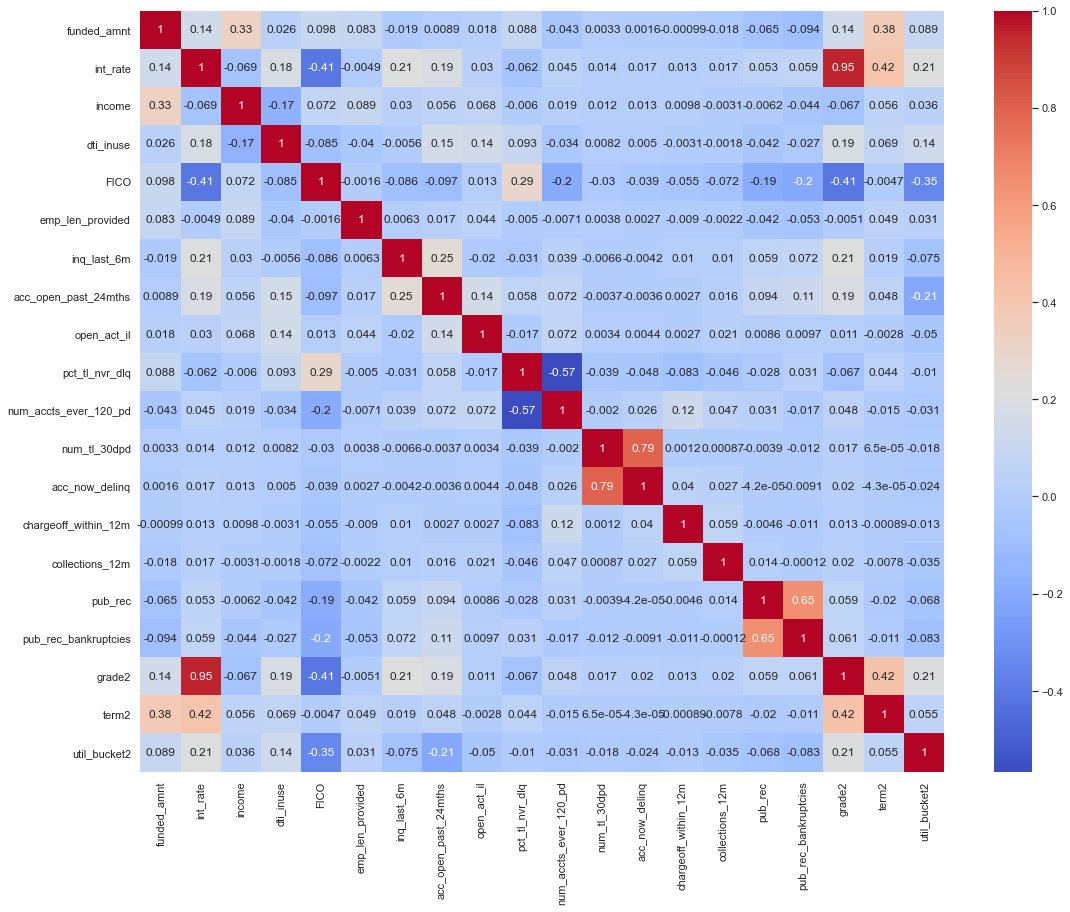

In [219]:
correlation_matrices(loan_feature, accepted,.5 )

In [220]:
'''#plt.figure(figsize=(20,20))
correlation_matrices(f_num)'''

'#plt.figure(figsize=(20,20))\ncorrelation_matrices(f_num)'

In [221]:
loan_feature.remove('pct_tl_nvr_dlq')
loan_feature.remove('pub_rec_bankruptcies')
loan_feature.remove('num_tl_30dpd')
loan_feature.remove('int_rate')

In [222]:
loan_feature

['funded_amnt',
 'purpose',
 'income',
 'dti_inuse',
 'FICO',
 'emp_len_provided',
 'inq_last_6m',
 'acc_open_past_24mths',
 'open_act_il',
 'num_accts_ever_120_pd',
 'acc_now_delinq',
 'chargeoff_within_12m',
 'collections_12m',
 'pub_rec',
 'grade2',
 'term2',
 'util_bucket2']

Round 2

In [223]:
vif_test(loan_feature,accepted)

                  feature        VIF
0             funded_amnt   4.999490
1                  income   2.687586
2               dti_inuse   6.480564
3                    FICO  28.031961
4        emp_len_provided  17.087151
5             inq_last_6m   1.662940
6    acc_open_past_24mths   3.975060
7             open_act_il   1.300433
8   num_accts_ever_120_pd   1.175340
9          acc_now_delinq   1.008846
10   chargeoff_within_12m   1.027028
11        collections_12m   1.021783
12                pub_rec   1.149569
13                 grade2   7.878825
14                  term2   1.854828
15           util_bucket2   8.684246


funded_amnt  funded_amnt   NaN
dtype: float64

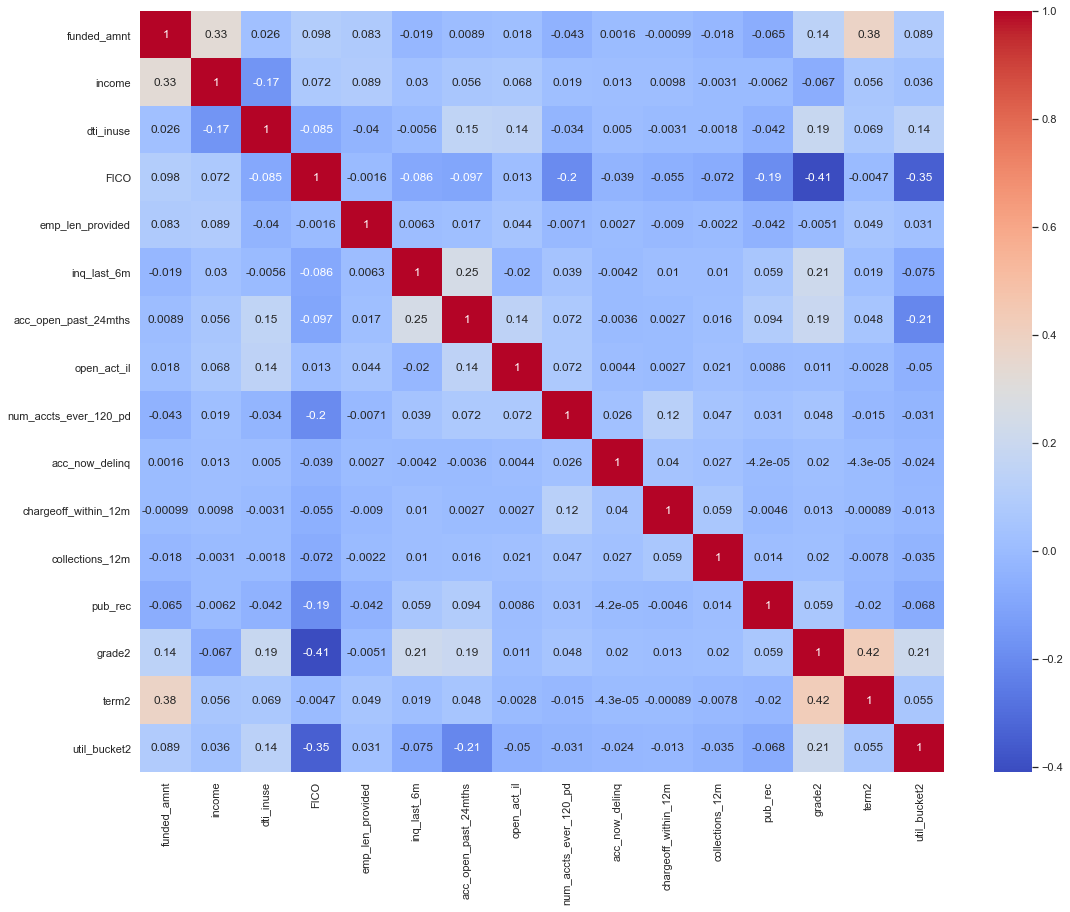

In [224]:
correlation_matrices(loan_feature, accepted,.5 )

Round 3

In [225]:
### ver 3
loan_feature3 = loan_feature.copy()
loan_feature3.remove('FICO')

In [226]:
vif_test(loan_feature3,accepted)

                  feature       VIF
0             funded_amnt  4.838461
1                  income  2.653596
2               dti_inuse  5.946706
3        emp_len_provided  9.569539
4             inq_last_6m  1.660679
5    acc_open_past_24mths  3.852767
6             open_act_il  1.300059
7   num_accts_ever_120_pd  1.174776
8          acc_now_delinq  1.008846
9    chargeoff_within_12m  1.027004
10        collections_12m  1.021671
11                pub_rec  1.145636
12                 grade2  7.793011
13                  term2  1.834786
14           util_bucket2  7.986619


funded_amnt  funded_amnt   NaN
dtype: float64

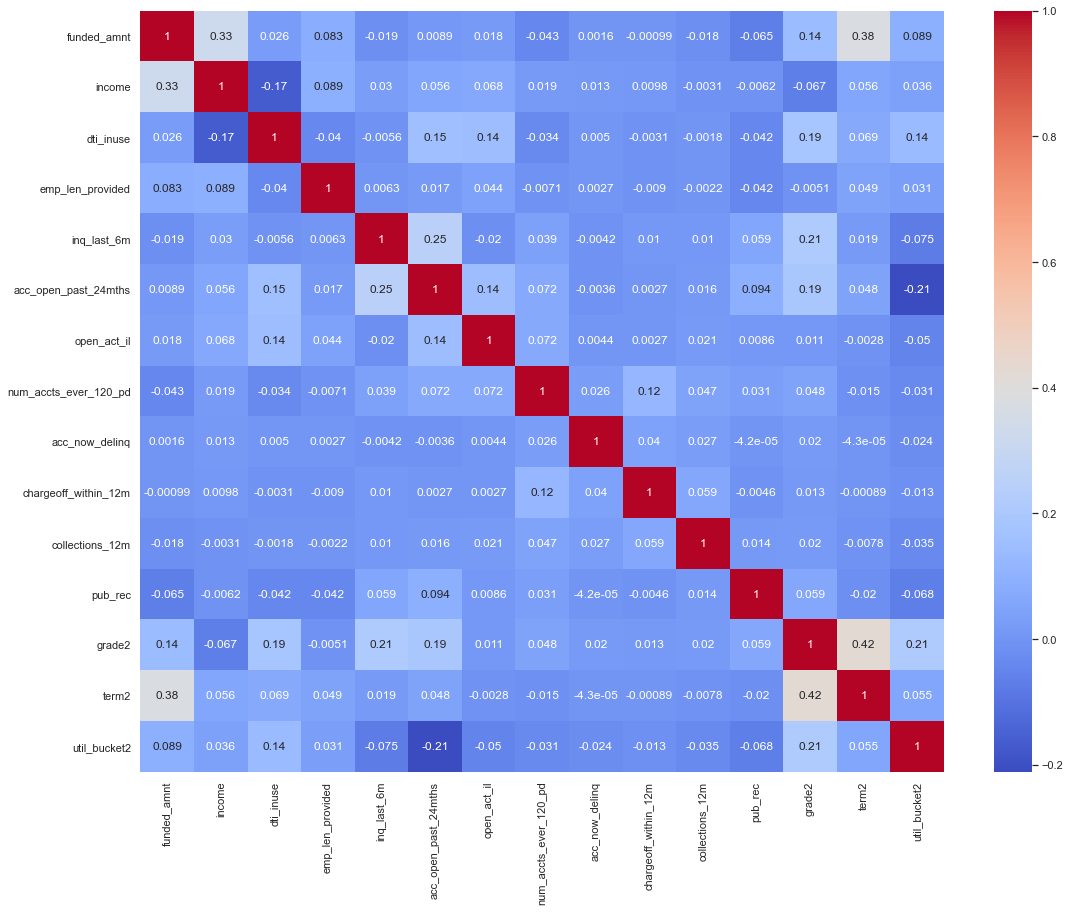

In [227]:
correlation_matrices(loan_feature3, accepted,.5 )

Round 4

In [228]:
### ver 4
#loan_feature

In [229]:
loan_feature4 = ['funded_amnt',
 'purpose',
 'income',
 'dti_inuse',
 'emp_len_provided',
 'FICO',
# 'inq_last_6m',
# 'acc_open_past_24mths',
# 'open_act_il',
# 'num_accts_ever_120_pd',
# 'acc_now_delinq',
# 'chargeoff_within_12m',
# 'collections_12m',
# 'pub_rec',
 'grade2',
 'term2',
# 'util_bucket2'
]

In [230]:
vif_test(loan_feature4,accepted)

            feature        VIF
0       funded_amnt   4.952019
1            income   2.611149
2         dti_inuse   5.981207
3  emp_len_provided  16.869609
4              FICO  25.244435
5            grade2   6.485960
6             term2   1.823163


funded_amnt  funded_amnt   NaN
dtype: float64

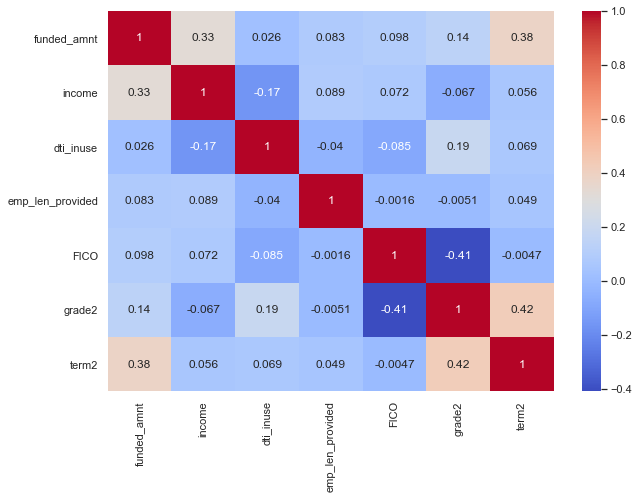

In [231]:
plt.figure(figsize=(10,7))
correlation_matrices(loan_feature4, accepted,.5 )

**Step5 - Combined with Macro-econ variables**

In [232]:
'''# US annual CPI
cpi = pd.read_csv('data/US_CPI.csv')#, index_col=0) # national

# US real GDP
gdp = pd.read_csv('data/US_GDP.csv')#, index_col=0) # national

# statewise monthly unemployment rate
unemployment = pd.read_csv('data/US_statewide_unemployment_rate.csv')#, index_col=0) # state



gdp['gdp_growth'] = gdp['Value'].pct_change()*100
#gdp['gdp_growth']'''

"# US annual CPI\ncpi = pd.read_csv('data/US_CPI.csv')#, index_col=0) # national\n\n# US real GDP\ngdp = pd.read_csv('data/US_GDP.csv')#, index_col=0) # national\n\n# statewise monthly unemployment rate\nunemployment = pd.read_csv('data/US_statewide_unemployment_rate.csv')#, index_col=0) # state\n\n\n\ngdp['gdp_growth'] = gdp['Value'].pct_change()*100\n#gdp['gdp_growth']"

**1. CPI**

In [233]:
cpi.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value
0,USA,CPI,TOT,AGRWTH,A,2000,3.376857
1,USA,CPI,TOT,AGRWTH,A,2001,2.826171
2,USA,CPI,TOT,AGRWTH,A,2002,1.586032
3,USA,CPI,TOT,AGRWTH,A,2003,2.270095
4,USA,CPI,TOT,AGRWTH,A,2004,2.677237


In [234]:
right_cpi = cpi[['TIME','Value']]
right_cpi.columns = ['issue_yr','cpi']
accepted = accepted.merge(right_cpi, on='issue_yr', how='left')
#accepted.head()

**2. real GDP growth**

In [235]:
gdp.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,gdp_growth
0,USA,GDP,TOT,MLN_USD,A,1999,9631172,NaN
1,USA,GDP,TOT,MLN_USD,A,2000,10250952,6.435146
2,USA,GDP,TOT,MLN_USD,A,2001,10581929,3.228744
3,USA,GDP,TOT,MLN_USD,A,2002,10929108,3.280867
4,USA,GDP,TOT,MLN_USD,A,2003,11456450,4.825115


In [236]:
right_gdp = gdp[['TIME','gdp_growth']]
right_gdp.columns = ['issue_yr','gdp_growth']
accepted = accepted.merge(right_gdp, on='issue_yr', how='left')
#accepted.head()

**3. state-wise umemployment rate**

In [237]:
#unemployment = pd.read_csv('data/US_statewide_unemployment_rate.csv')

In [238]:
unemployment.head()

,Series ID,State,Year,Period,Label,Value
0,LASST010000000000003,AL,2006,M01,2006 Jan,4.1
1,LASST010000000000003,AL,2006,M02,2006 Feb,4.1
2,LASST010000000000003,AL,2006,M03,2006 Mar,4.1
3,LASST010000000000003,AL,2006,M04,2006 Apr,4.1
4,LASST010000000000003,AL,2006,M05,2006 May,4.1


In [239]:
unemployment['issue_dt'] = pd.to_datetime(unemployment['Label'].apply(lambda x: datetime.datetime.strptime(x, '%Y %b')))
#unemployment.head()
right_unemployment = unemployment[['State','issue_dt','Value']]

right_unemployment.columns = ['addr_state','issue_dt','unemployment']
accepted = accepted.merge(right_unemployment, on=['addr_state','issue_dt'], how='left')
#accepted.head()

Round 2.1 - with FICO

In [240]:
# loan_feature

In [241]:
loan_feature21 = loan_feature.copy()

for f in ['cpi','gdp_growth','unemployment']:
    loan_feature21.append(f)

In [242]:
#loan_feature21

                  feature        VIF
0             funded_amnt   5.017192
1                  income   2.690152
2               dti_inuse   6.606111
3                    FICO  63.877918
4        emp_len_provided  17.177065
5             inq_last_6m   1.681244
6    acc_open_past_24mths   3.981680
7             open_act_il   1.668160
8   num_accts_ever_120_pd   1.182997
9          acc_now_delinq   1.009005
10   chargeoff_within_12m   1.027172
11        collections_12m   1.022635
12                pub_rec   1.153176
13                 grade2   7.932382
14                  term2   1.855933
15           util_bucket2   8.894329
16                    cpi   4.484004
17             gdp_growth  30.011041
18           unemployment  17.071499


funded_amnt  funded_amnt   NaN
dtype: float64

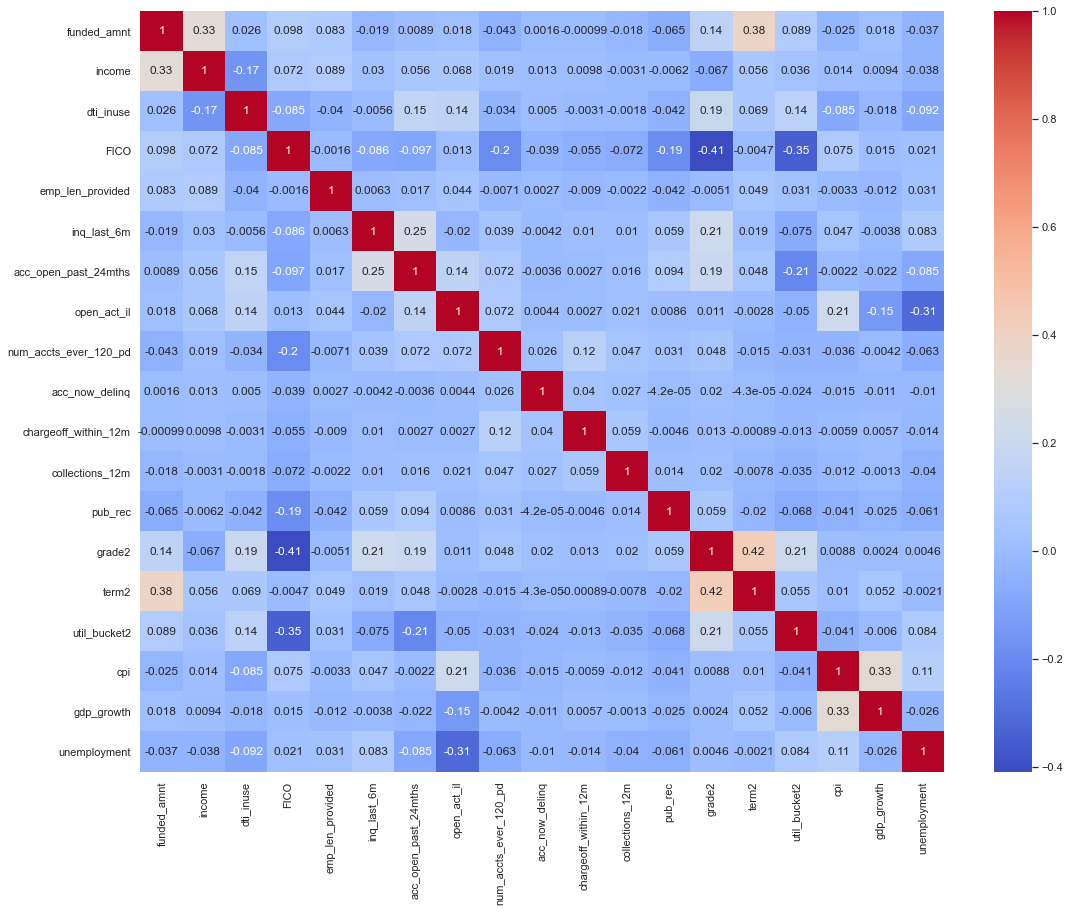

In [243]:
vif_test(loan_feature21,accepted)
correlation_matrices(loan_feature21, accepted,.5 )

Round 3.1 -- W/O FICO

In [244]:
loan_feature31 = loan_feature3.copy()

for f in ['cpi','gdp_growth','unemployment']:
    loan_feature31.append(f)

                  feature        VIF
0             funded_amnt   4.903911
1                  income   2.674820
2               dti_inuse   6.350743
3        emp_len_provided  14.467936
4             inq_last_6m   1.680857
5    acc_open_past_24mths   3.933495
6             open_act_il   1.579823
7   num_accts_ever_120_pd   1.182865
8          acc_now_delinq   1.009003
9    chargeoff_within_12m   1.027161
10        collections_12m   1.022587
11                pub_rec   1.151223
12                 grade2   7.931218
13                  term2   1.844694
14           util_bucket2   8.830787
15                    cpi   4.446346
16             gdp_growth  19.775636
17           unemployment  13.009870


funded_amnt  funded_amnt   NaN
dtype: float64

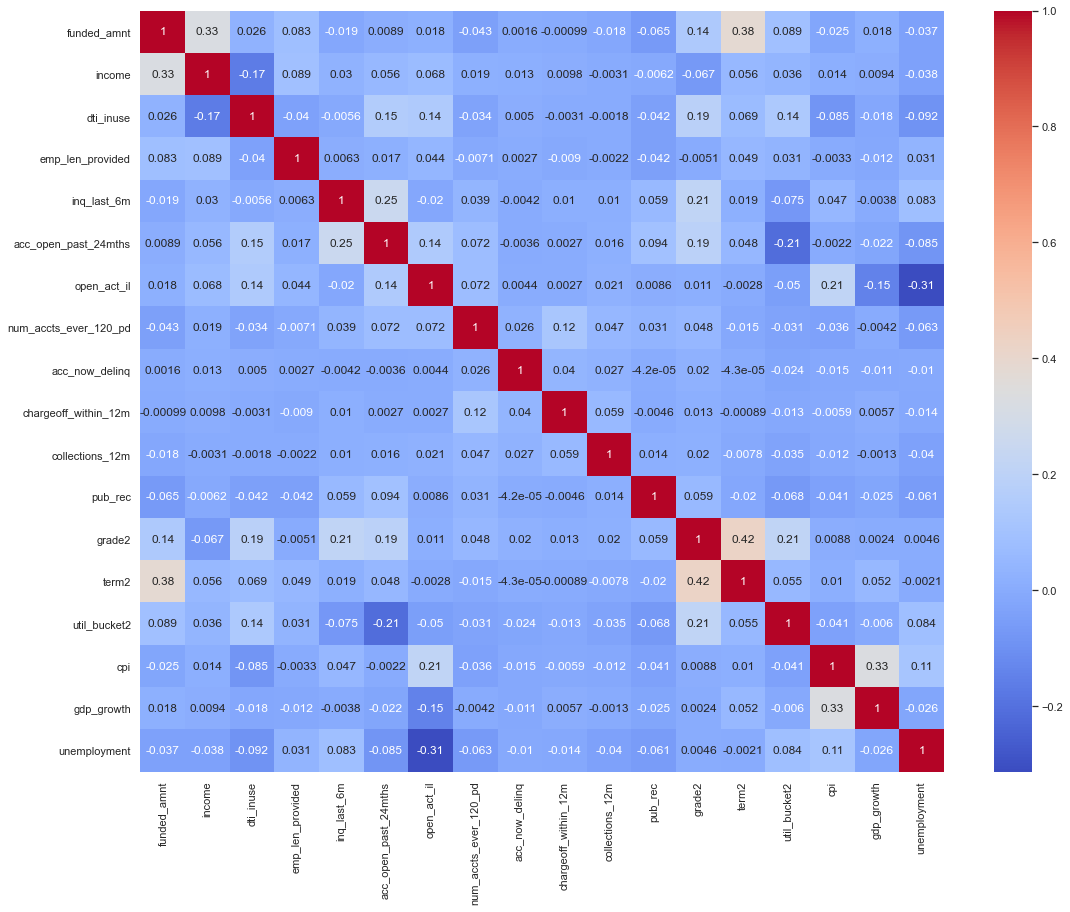

In [245]:
vif_test(loan_feature31,accepted)
correlation_matrices(loan_feature31, accepted,.5 )

In [246]:
list2 = loan_feature21.copy()
list3 = loan_feature31.copy()

In [247]:
list3

['funded_amnt',
 'purpose',
 'income',
 'dti_inuse',
 'emp_len_provided',
 'inq_last_6m',
 'acc_open_past_24mths',
 'open_act_il',
 'num_accts_ever_120_pd',
 'acc_now_delinq',
 'chargeoff_within_12m',
 'collections_12m',
 'pub_rec',
 'grade2',
 'term2',
 'util_bucket2',
 'cpi',
 'gdp_growth',
 'unemployment']

Round 3.11 -- W/O FICO, W/O gdp_growth

                  feature        VIF
0             funded_amnt   4.856092
1                  income   2.659042
2               dti_inuse   6.052264
3        emp_len_provided  12.639204
4             inq_last_6m   1.679374
5    acc_open_past_24mths   3.881033
6             open_act_il   1.529031
7   num_accts_ever_120_pd   1.176579
8          acc_now_delinq   1.008999
9    chargeoff_within_12m   1.027021
10        collections_12m   1.021825
11                pub_rec   1.146273
12                 grade2   7.893763
13                  term2   1.842758
14           util_bucket2   8.603253
15                    cpi   3.660389
16           unemployment  12.460576


funded_amnt  funded_amnt   NaN
dtype: float64

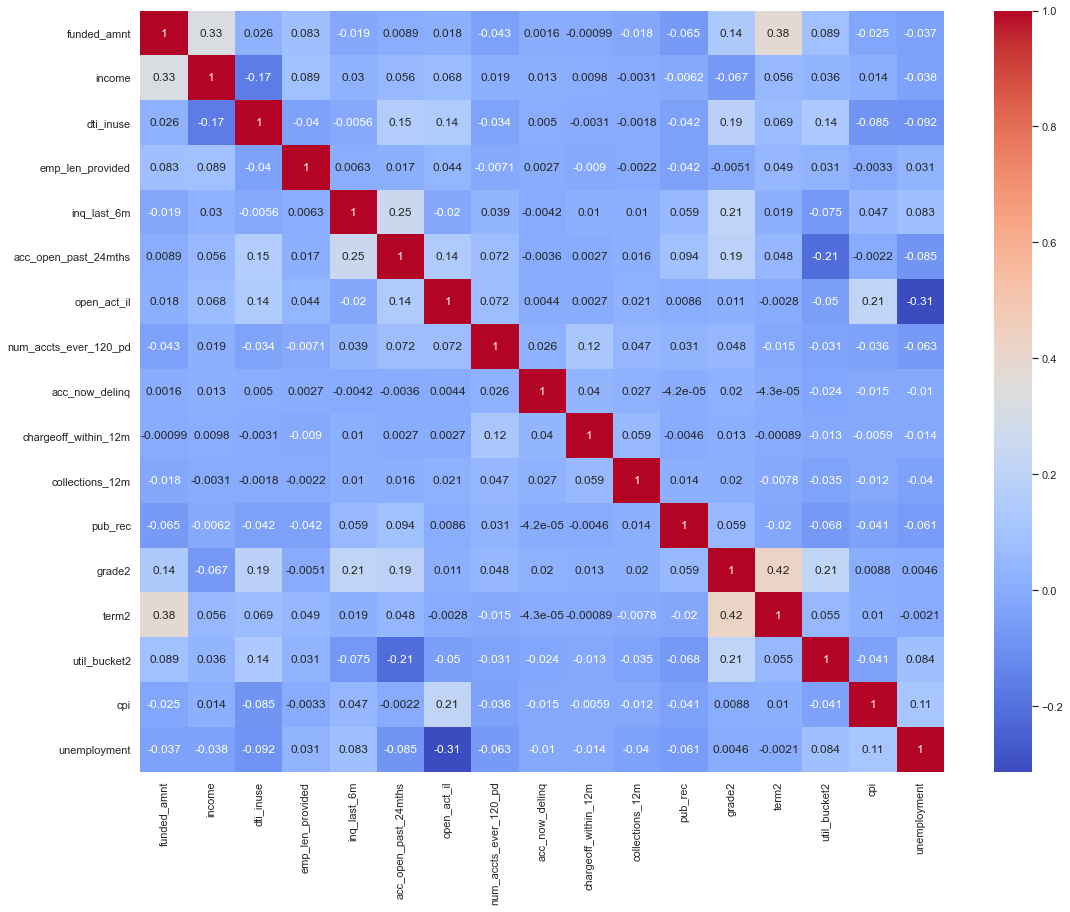

In [248]:
loan_feature311 = loan_feature31.copy()
loan_feature311.remove('gdp_growth')

vif_test(loan_feature311,accepted)
correlation_matrices(loan_feature311, accepted,.5 )

Round 3.12 -- W/O FICO, W/O gdp_growth, umployment

                  feature        VIF
0             funded_amnt   4.840347
1                  income   2.655788
2               dti_inuse   5.949671
3        emp_len_provided  10.251371
4             inq_last_6m   1.667384
5    acc_open_past_24mths   3.856871
6             open_act_il   1.366795
7   num_accts_ever_120_pd   1.176388
8          acc_now_delinq   1.008971
9    chargeoff_within_12m   1.027021
10        collections_12m   1.021723
11                pub_rec   1.146076
12                 grade2   7.848697
13                  term2   1.835867
14           util_bucket2   8.061882
15                    cpi   3.282674


funded_amnt  funded_amnt   NaN
dtype: float64

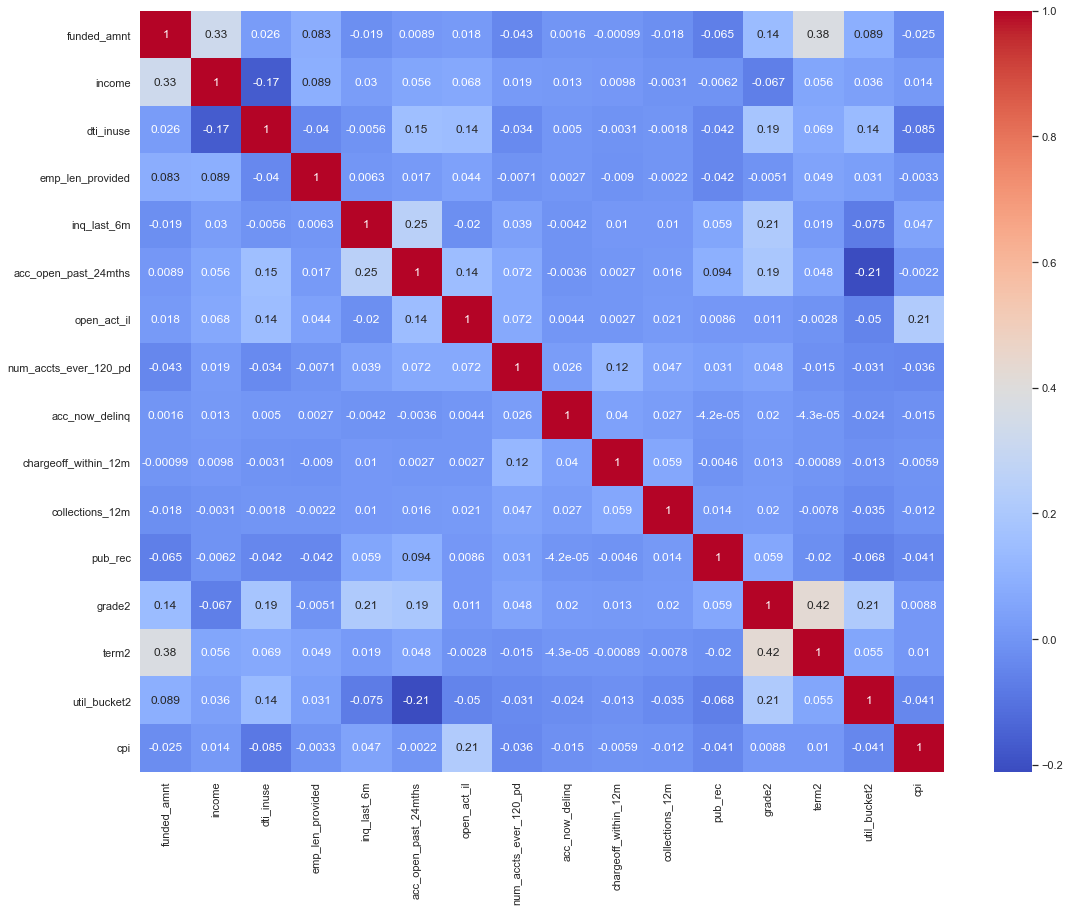

In [249]:
loan_feature312 = loan_feature31.copy()
loan_feature312.remove('gdp_growth')
loan_feature312.remove('unemployment')

vif_test(loan_feature312,accepted)
correlation_matrices(loan_feature312, accepted,.5 )

In [250]:
list2 = loan_feature21.copy()
list3 = loan_feature31.copy()
list31 = loan_feature311.copy()
list32 = loan_feature312.copy()

**Save a copy before cutting features**

In [251]:
###$$$###
accepted_mdl = accepted.copy()
#accepted_mdl = accepted_mdl[loan_feature2]

print(accepted.shape)
print(accepted_mdl.shape)

(1348068, 175)
(1348068, 175)


**Subsample by feature**

In [252]:
#feature_lst

In [253]:
#accepted.issue_yr

In [254]:
#feature_lst = list2.copy() ###$$$###
feature_lst = list3.copy() ###$$$###
#feature_lst = list31.copy() ###$$$###
#feature_lst = list32.copy() ###$$$###

feature_full = feature_lst.copy()
feature_full.append('id')
feature_full.append('roi')
feature_full.append('loan_status2')
feature_full.append('issue_yr')

In [255]:
#feature_lst

In [256]:
accepted_mdl = accepted_mdl[feature_full]
accepted_mdl.loan_status2.replace({'Fully Paid':0, 
                                    'Default':1}, inplace=True)

print(accepted_mdl.shape)

(1348068, 23)


In [257]:
#accepted.loan_status2.head()

### Sampling & Train test split

I - imbalanced ratio

In [258]:
accepted_mdl.loan_status2.value_counts().reset_index().loan_status2.div(accepted_mdl.shape[0])

0    0.80019
1    0.19981
Name: loan_status2, dtype: float64

In [259]:
accepted_mdl.shape

(1348068, 23)

- 4:1

II - separated into **0 - [Fully Paid]** & **1 - [Default]**

In [260]:
accepted_fp = accepted_mdl.loc[accepted_mdl.loan_status2 ==0].copy()
accepted_d = accepted_mdl.loc[accepted_mdl.loan_status2 ==1].copy()

print(accepted_mdl.shape)
print(accepted_fp.shape)
print(accepted_d.shape)

(1348068, 23)
(1078711, 23)
(269357, 23)


III - sample

In [261]:
from sklearn.model_selection import train_test_split

***Fully paid***

*** 1. Sample : Others

In [262]:
### fully paid - 0
fp1, fp2 = train_test_split(accepted_fp,
                         stratify=accepted_fp[['term2','grade2']],
                         train_size=20000,
                         random_state=413)
# fp1 - used for sample balanced train & test data
# fp2 - used for sample imbalanced test data

In [263]:
print(fp1.shape)
print(fp2.shape)

(20000, 23)
(1058711, 23)


*** 2. balanced train & test data

In [264]:
train1_fp, test1_fp = train_test_split(fp1,
                                       #stratify=X1[['term2','grade2']],
                                       test_size=4000,
                                       random_state=413)

print(train1_fp.shape)
print(test1_fp.shape)

(16000, 23)
(4000, 23)


*** 3. imbalanced test data

In [265]:
_, test2_fp = train_test_split(fp2,
                               #stratify=X1[['term2','grade2']],
                               test_size=6400,
                               random_state=413)

#print(train1_fp.shape)
print(test2_fp.shape)

(6400, 23)


*** 4. imbalanced test data 2007

In [266]:
n = 500
n*(accepted[accepted.issue_yr == 2007].loan_status2.value_counts() / accepted[accepted.issue_yr == 2007].shape[0])
# 364
# 136

Fully Paid    364.982578
Default       135.017422
Name: loan_status2, dtype: float64

In [267]:
_, test2007_fp = train_test_split(fp2[fp2.issue_yr == 2011],
                               #stratify=X1[['term2','grade2']],
                               test_size=364,
                               random_state=413)

#print(train1_fp.shape)
print(test2007_fp.shape)

(364, 23)


*** 5. imbalanced test data 2011

In [268]:
n = 500
n*(accepted[accepted.issue_yr == 2011].loan_status2.value_counts() / accepted[accepted.issue_yr == 2011].shape[0])
# 424
# 76

Fully Paid    424.105704
Default        75.894296
Name: loan_status2, dtype: float64

In [269]:
_, test2011_fp = train_test_split(fp2[fp2.issue_yr == 2011],
                               #stratify=X1[['term2','grade2']],
                               test_size=424,
                               random_state=413)

#print(train1_fp.shape)
print(test2011_fp.shape)

(424, 23)


*** 6. imbalanced test data 2009

In [270]:
n = 500
#yr = 2009

n*(accepted[accepted.issue_yr == 2009].loan_status2.value_counts() / accepted[accepted.issue_yr == 2009].shape[0])
# 431
# 69

Fully Paid    431.547055
Default        68.452945
Name: loan_status2, dtype: float64

In [271]:
_, test2009_fp = train_test_split(fp2[fp2.issue_yr == 2009],
                               #stratify=X1[['term2','grade2']],
                               test_size=431,
                               random_state=413)

#print(train1_fp.shape)
print(test2009_fp.shape)

(431, 23)


***Default***

*** 1. sample : other

In [272]:
### default - 1
d1, d2 = train_test_split(accepted_d,
                        stratify=accepted_d[['term2','grade2']],
                        train_size=20000,
                         random_state=413)

# d1 - used for sample balanced train & test data
# d2 - used for sample imbalanced test data

In [273]:
print(d1.shape)
print(d2.shape)

(20000, 23)
(249357, 23)


*** 2. balanced train & test data

In [274]:
train1_d, test1_d = train_test_split(d1,
                                     #stratify=X1[['term2','grade2']],
                                     test_size=4000,
                                     random_state=413)

print(train1_d.shape)
print(test1_d.shape)

(16000, 23)
(4000, 23)


*** 3. imbalanced test data

In [275]:
_, test2_d = train_test_split(d2,
                              #stratify=X1[['term2','grade2']],
                              test_size=1600,
                              random_state=413)

#print(train1_fp.shape)
print(test2_d.shape)

(1600, 23)


*** 4. imbalanced test data 2

In [276]:
# 136
_, test2007_d = train_test_split(d2[d2.issue_yr == 2007],
                               #stratify=X1[['term2','grade2']],
                               test_size=136,
                               random_state=413)

#print(train1_fp.shape)
print(test2007_d.shape)

(136, 23)


*** 5. imbalanced test data 2011

In [277]:
# 76
_, test2011_d = train_test_split(d2[d2.issue_yr == 2011],
                               #stratify=X1[['term2','grade2']],
                               test_size=76,
                               random_state=413)

#print(train1_fp.shape)
print(test2011_d.shape)

(76, 23)


*** 6. imbalanced test data 2009

In [278]:
# 69
_, test2009_d = train_test_split(d2[d2.issue_yr == 2009],
                               #stratify=X1[['term2','grade2']],
                               test_size=69,
                               random_state=413)

#print(train1_fp.shape)
print(test2009_d.shape)

(69, 23)


***Combine and get train, test sets***

In [279]:
train = pd.concat([train1_fp, train1_d]) 
test1 = pd.concat([test1_fp, test1_d]) 
test2 = pd.concat([test2_fp, test2_d]) 


test2007 = pd.concat([test2007_fp, test2007_d]) 
test2011 = pd.concat([test2011_fp, test2011_d]) 
test2009 = pd.concat([test2009_fp, test2009_d]) 

print(train.shape)
print(test1.shape)
print(test2.shape)

print(test2007.shape)
print(test2011.shape)

(32000, 23)
(8000, 23)
(8000, 23)
(500, 23)
(500, 23)


In [280]:
print(train.loan_status2.value_counts())
print(test1.loan_status2.value_counts())
print(test2.loan_status2.value_counts())

0    16000
1    16000
Name: loan_status2, dtype: int64
0    4000
1    4000
Name: loan_status2, dtype: int64
0    6400
1    1600
Name: loan_status2, dtype: int64


## Real ROI

In [281]:
test1.roi.mean()

-0.14714841250000024

In [282]:
test2.roi.mean()

0.03388507500000029

In [283]:
test2007.roi.mean()

0.024444599999999976

In [284]:
test2011.roi.mean()

0.10178040000000013

In [285]:
test2009.roi.mean()

0.08356100000000004

***Split x and y***

In [286]:
train_X = train[feature_lst]
train_y = train['loan_status2']

print(train_X.shape)
print(len(train_y))

(32000, 19)
32000


In [287]:
test1_X = test1[feature_lst]
test1_y = test1['loan_status2']

print(test1_X.shape)
print(len(test1_y))

(8000, 19)
8000


In [288]:
test2_X = test2[feature_lst]
test2_y = test2['loan_status2']

print(test2_X.shape)
print(len(test2_y))

(8000, 19)
8000


In [289]:
test2007_X = test2007[feature_lst]
test2007_y = test2007['loan_status2']

print(test2007_X.shape)
print(len(test2007_y))

(500, 19)
500


In [290]:
test2011_X = test2011[feature_lst]
test2011_y = test2011['loan_status2']

print(test2011_X.shape)
print(len(test2011_y))

(500, 19)
500


In [291]:
'''train_X = train.copy()
train_X = train_X.drop(columns=['loan_status2'])


train_y = train['loan_status2']

print(train_X.shape)
print(train_y.shape)'''

"train_X = train.copy()\ntrain_X = train_X.drop(columns=['loan_status2'])\n\n\ntrain_y = train['loan_status2']\n\nprint(train_X.shape)\nprint(train_y.shape)"

In [292]:
'''test_X = test.copy()
test_X = test_X.drop(columns=['loan_status2'])


test_y = test['loan_status2']

print(test_X.shape)
print(test_y.shape)'''

"test_X = test.copy()\ntest_X = test_X.drop(columns=['loan_status2'])\n\n\ntest_y = test['loan_status2']\n\nprint(test_X.shape)\nprint(test_y.shape)"

In [356]:
test2009_X = test2009[feature_lst]
test2009_y = test2009['loan_status2']

print(test2009_X.shape)
print(len(test2009_y))

(500, 19)
500


## III. ML Model

#### Dummification

In [294]:
#train_X.dtypes

In [295]:
train_X = pd.get_dummies(train_X ,drop_first=False).drop(['purpose_wedding'], axis=1)
print(train_X .shape)

(32000, 31)


In [296]:
test1_X = pd.get_dummies(test1_X ,drop_first=False).drop(['purpose_wedding'], axis=1)
print(test1_X.shape)

(8000, 31)


In [297]:
test2_X = pd.get_dummies(test2_X ,drop_first=False).drop(['purpose_wedding'], axis=1)
print(test2_X.shape)

(8000, 31)


In [298]:
test2007_X = pd.get_dummies(test2007_X ,drop_first=False).drop(['purpose_wedding'], axis=1)
print(test2007_X.shape)

(500, 31)


In [299]:
test2011_X = pd.get_dummies(test2011_X ,drop_first=False).drop(['purpose_wedding'], axis=1)
print(test2011_X.shape)



(500, 30)


In [357]:
test2009_X = pd.get_dummies(test2009_X ,drop_first=False).drop(['purpose_wedding'], axis=1)
print(test2009_X.shape)


(500, 30)


In [358]:
test2009_X.columns.tolist()[28]
test2009_X.insert(28,'purpose_renewable_energy',0)

In [359]:
#test2009_X.columns.tolist()
print(test2009_X.shape)

(500, 31)


In [303]:
test2007_X.columns.tolist()[21]

'purpose_educational'

In [304]:
test2011_X.insert(21,'purpose_educational',0)

In [305]:
test2011_X.purpose_educational.sum()

0

In [306]:
print(len(test2011_X.columns.tolist()))
#test2011_X.columns.tolist()

31


**Model fitting**

***GridSearchCV 1***  
Larger range of hyperparam for tunning

In [307]:
'''# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), 
      #"penalty": ["l2"]}# l1 lasso l2 ridge
      "penalty":['l1',"l2",'elasticnet', 'none'],
      #"solver":['lbfgs','liblinear',]
      "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
     }# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,grid,cv=10)
result = logreg_cv.fit(train_X, train_y)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)'''

'# Grid search cross validation\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.linear_model import LogisticRegression\n\ngrid={"C":np.logspace(-3,3,7), \n      #"penalty": ["l2"]}# l1 lasso l2 ridge\n      "penalty":[\'l1\',"l2",\'elasticnet\', \'none\'],\n      #"solver":[\'lbfgs\',\'liblinear\',]\n      "solver":[\'newton-cg\', \'lbfgs\', \'liblinear\', \'sag\', \'saga\']\n     }# l1 lasso l2 ridge\n\nlogreg = LogisticRegression()\nlogreg_cv = GridSearchCV(logreg,grid,cv=10)\nresult = logreg_cv.fit(train_X, train_y)\n\nprint("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)\nprint("accuracy :",logreg_cv.best_score_)'

In [308]:
### tune 1: tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
# accuracy : 0.6515625

In [309]:
# tune 2: tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
# accuracy : 0.6503125

In [310]:
'''from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
from sklearn import metrics
#from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

#lm.score(X_train1, y_train1)

###### valuation - 1.linear ######
# Predict
y_pred = logreg_cv.predict(test1_X)

# RMSE
#print(np.sqrt(metrics.mean_squared_error(test1_y, y_pred)))

# r2_score
#r2_score(test1_y, y_pred)
accuracy_score(test1_y, y_pred)'''

'from sklearn.linear_model import LinearRegression\n#from sklearn.metrics import mean_squared_error\nfrom sklearn import metrics\n#from sklearn.metrics import r2_score\nfrom sklearn.metrics import accuracy_score\n\n#lm.score(X_train1, y_train1)\n\n###### valuation - 1.linear ######\n# Predict\ny_pred = logreg_cv.predict(test1_X)\n\n# RMSE\n#print(np.sqrt(metrics.mean_squared_error(test1_y, y_pred)))\n\n# r2_score\n#r2_score(test1_y, y_pred)\naccuracy_score(test1_y, y_pred)'

In [311]:
### 0.64325
### 0.5972855263607181

In [312]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

***GridSearchCV 2***  
Narrow down the range of hyperparam for tunning based on GridSearch1 results

<font color='red'>**NO need to rerun if NO change to model fitting**</font>


In [313]:
#train_X

In [314]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid2={"C":np.logspace(-3,3,7), 
      #"penalty": ["l2"]}# l1 lasso l2 ridge
      "penalty":["l2",'elasticnet'],#, 'none'],
      #"solver":['lbfgs','liblinear',]
      "solver":['lbfgs', 'liblinear', 'sag', 'saga']
     }# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv2 = GridSearchCV(logreg,grid2,cv=10)
result2 = logreg_cv2.fit(train_X, train_y)

print("tuned hpyerparameters :(best parameters) ",logreg_cv2.best_params_)
print("accuracy :",logreg_cv2.best_score_)

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached wh

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/xue/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached wh

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.64646875


In [315]:
# tuned 1 - tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
# accuracy : 0.64446875

**Final model:**  
tuned 2 -   
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
 accuracy : 0.64646875

In [316]:
# tune 3 - tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
# accuracy : 0.64453125

In [317]:
# tune 4 - tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
# accuracy : 0.6346249999999999

In [318]:
from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
from sklearn import metrics
#from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

#lm.score(X_train1, y_train1)

###### valuation - 1.linear ######
# Predict
y_pred = logreg_cv2.predict(test1_X)

# RMSE
#print(np.sqrt(metrics.mean_squared_error(test1_y, y_pred)))

# r2_score
#r2_score(test1_y, y_pred)

# accuracy
accuracy_score(test1_y, y_pred)

0.637375

In [319]:
# 0.637375

In [320]:
'''importance = result.best_estimator_.coef_[0]

feature_list = test1_X.columns
feat_importances = pd.Series(importance, index = feature_list).sort_values(ascending=False)

feat_importances'''

'importance = result.best_estimator_.coef_[0]\n\nfeature_list = test1_X.columns\nfeat_importances = pd.Series(importance, index = feature_list).sort_values(ascending=False)\n\nfeat_importances'

In [321]:
'''feat_importances.plot(kind='barh',title = 'Feature Importance')'''

"feat_importances.plot(kind='barh',title = 'Feature Importance')"

In [322]:
importance = result2.best_estimator_.coef_[0]

feature_list = test1_X.columns
feat_importances = pd.Series(importance, index = feature_list).sort_values(ascending=False)

feat_importances

grade2                        0.405620
term2                         0.121378
inq_last_6m                   0.077897
util_bucket2                  0.030586
acc_open_past_24mths          0.027599
pub_rec                       0.020937
purpose_small_business        0.008740
collections_12m               0.006588
dti_inuse                     0.005798
num_accts_ever_120_pd         0.005733
purpose_other                 0.004700
chargeoff_within_12m          0.002548
purpose_major_purchase        0.002242
acc_now_delinq                0.001954
purpose_moving                0.000892
purpose_renewable_energy      0.000623
purpose_house                 0.000461
purpose_vacation              0.000154
funded_amnt                   0.000013
income                       -0.000005
purpose_medical              -0.000038
open_act_il                  -0.000069
purpose_educational          -0.000162
purpose_car                  -0.002302
purpose_home_improvement     -0.004920
purpose_debt_consolidatio

Text(0.5, 1.0, 'Feature Importance')

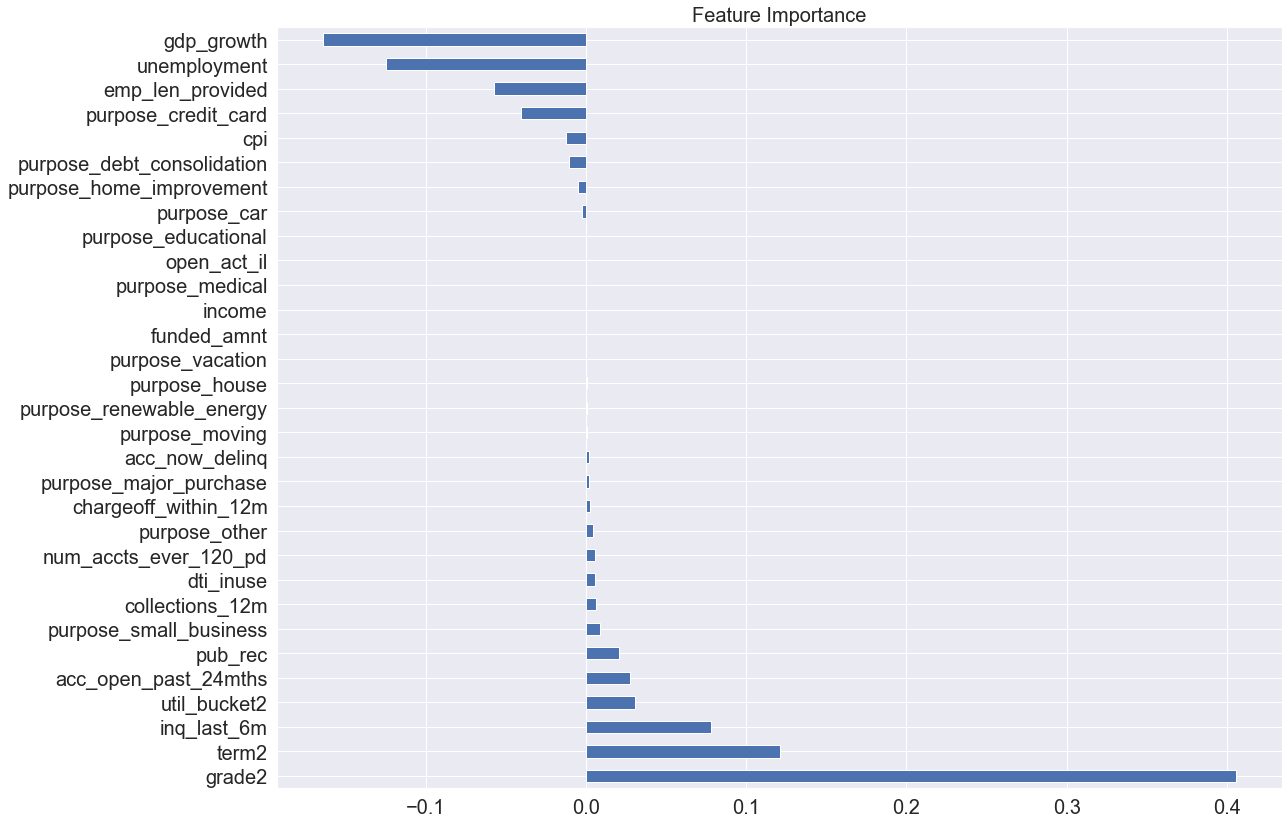

In [323]:
feat_importances.plot(kind='barh',title = 'Feature Importance',fontsize=20,)
feat_importances.plot(kind='barh',fontsize=20)
plt.title('Feature Importance',fontsize=20)
#plt.ylabel('Count (%)',fontsize=15)

Positive coeffcients lead to higher on default probability:
1. Grade  
2. Term  
3. inquiries for last 6 months

Negative coefficients:
1. GDP growth%
2. Unemployment rate - this is a surprising result. Probably because of lagging effect.

In [324]:
#np.exp(feat_importances)

In [325]:
'''logistic_model.fit(X,Y)
importance = logistic_model.coef_[0]
#importance is a list so you can plot it. 
feat_importances = pd.Series(importance)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')'''

"logistic_model.fit(X,Y)\nimportance = logistic_model.coef_[0]\n#importance is a list so you can plot it. \nfeat_importances = pd.Series(importance)\nfeat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')"

In [326]:
#from sklearn.ensemble import RandomForestRegressor

**Confusion Matrix***

***Testset 1***

In [327]:
### confusion matrix
from sklearn.metrics import confusion_matrix
m = confusion_matrix(test1_y, y_pred)
m

array([[2530, 1470],
       [1431, 2569]])

In [328]:
'''plt.figure(figsize=(5,3))
sns.heatmap(m)'''

'plt.figure(figsize=(5,3))\nsns.heatmap(m)'

In [329]:
'''import seaborn as sns
sns.heatmap(m, annot=True)'''

'import seaborn as sns\nsns.heatmap(m, annot=True)'

In [330]:
from sklearn import metrics
import numpy as np
y_pred = np.around(logreg_cv2.predict(test1_X))
print(metrics.classification_report(test1_y,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.64      4000
           1       0.64      0.64      0.64      4000

    accuracy                           0.64      8000
   macro avg       0.64      0.64      0.64      8000
weighted avg       0.64      0.64      0.64      8000



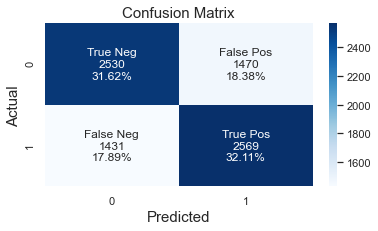

In [331]:
cf_matrix = m
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6,3))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


plt.xlabel('Predicted',fontsize=15)#,rotation = 45)
plt.ylabel('Actual',fontsize=15)
#plt.legend(title='Confusion Matrix')
#plt.legend().remove()
plt.title('Confusion Matrix',fontsize=15)

plt.show(g)

In [332]:
#(2586)/(2557+1443)

In [333]:
2530/(2530+1431)

0.6387275940419086

In [334]:
'''from sklearn.metrics import plot_confusion_matrix

 
#color = 'white'
matrix = plot_confusion_matrix(logreg_cv, test_X, test_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix')#, color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()'''

"from sklearn.metrics import plot_confusion_matrix\n\n \n#color = 'white'\nmatrix = plot_confusion_matrix(logreg_cv, test_X, test_y, cmap=plt.cm.Blues)\nmatrix.ax_.set_title('Confusion Matrix')#, color=color)\nplt.xlabel('Predicted Label', color=color)\nplt.ylabel('True Label', color=color)\nplt.gcf().axes[0].tick_params(colors=color)\nplt.gcf().axes[1].tick_params(colors=color)\nplt.show()"

In [335]:
### AUC Score

In [336]:
from sklearn.metrics import roc_auc_score
roc_auc1 = roc_auc_score(test1_y, y_pred)
print("Area under the ROC curve : %f" % roc_auc1)

Area under the ROC curve : 0.637375


In [337]:
from sklearn.metrics import roc_auc_score
#roc_auc1 = roc_auc_score(test1_y, y_pred)
roc_auc1 = roc_auc_score(train_y, logreg_cv2.predict(train_X))

print("Area under the ROC curve : %f" % roc_auc1)

Area under the ROC curve : 0.646344


In [338]:
#train_X

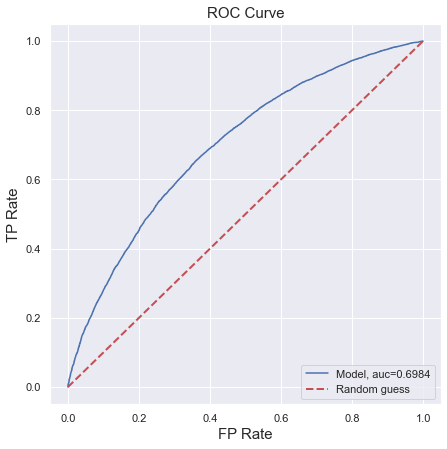

In [340]:
plt.figure(figsize=(7,7))

y_pred_proba = logreg_cv2.predict_proba(train_X)[::,1]
fpr, tpr, _ = metrics.roc_curve(train_y,  y_pred_proba)
auc = metrics.roc_auc_score(train_y, y_pred_proba)
plt.plot(fpr,tpr,label="Model, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')

plt.xlabel('FP Rate',fontsize=15)#,rotation = 45)
#plt.xticks(rotation=20)
plt.ylabel('TP Rate',fontsize=15)
#plt.legend(title='verification  Status')
#plt.legend().remove()
plt.title('ROC Curve',fontsize=15)


plt.legend(loc=4)
plt.show()

***Testset 2***

In [341]:
from sklearn import metrics
import numpy as np
y_pred2 = np.around(logreg_cv2.predict(test2_X))
print(metrics.classification_report(test2_y,y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.63      0.74      6400
           1       0.31      0.65      0.42      1600

    accuracy                           0.64      8000
   macro avg       0.59      0.64      0.58      8000
weighted avg       0.76      0.64      0.67      8000



In [342]:
y_pred2 = logreg_cv2.predict(test2_X)
accuracy_score(test2_y, y_pred2)

0.63725

In [343]:
m2 = confusion_matrix(test2_y, y_pred2)
m2

array([[4055, 2345],
       [ 557, 1043]])

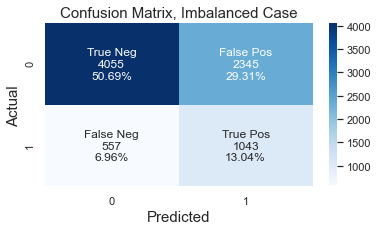

In [344]:
cf_matrix = m2
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6,3))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.xlabel('Predicted',fontsize=15)#,rotation = 45)
plt.ylabel('Actual',fontsize=15)
#plt.legend(title='Confusion Matrix')
#plt.legend().remove()
plt.title('Confusion Matrix, Imbalanced Case',fontsize=15)

plt.show(g)

In [345]:
test2_result = test2.copy()
test2_result['pred'] = y_pred2

test2_result[test2_result.pred == 0].roi.mean()

0.060970598438854946

In [346]:
test2_result[test2_result.pred == 0].groupby('issue_yr').agg({'roi':'mean'})

,roi
issue_yr,
2008,-0.100020
2009,-0.019580
2010,0.104739
2011,0.074037
2012,0.103584
2013,0.115438
2014,0.108357
2015,0.068612
2016,0.037950


***Testset - 2007,2011,2009***

In [347]:
### 2007

In [348]:
y_pred2007 = logreg_cv2.predict(test2007_X)
accuracy_score(test2007_y, y_pred2007)

0.838

In [349]:
test2007_result = test2007.copy()
test2007_result['pred'] = y_pred2007

test2007_result[test2007_result.pred == 0].roi.mean()

0.11492743362831848

In [350]:
### 2011

In [351]:
y_pred2011 = logreg_cv2.predict(test2011_X)
accuracy_score(test2011_y, y_pred2011)

0.782

In [352]:
test2011_result = test2011.copy()
test2011_result['pred'] = y_pred2011

test2011_result[test2011_result.pred == 0].roi.mean()

0.09381547911547891

In [353]:
### 2009

In [360]:
y_pred2009 = logreg_cv2.predict(test2009_X)
accuracy_score(test2009_y, y_pred2009)

0.444

In [361]:
test2009_result = test2009.copy()
test2009_result['pred'] = y_pred2009

test2009_result[test2009_result.pred == 0].roi.mean()

0.07483405405405402

In [362]:
'''y_pred2009 = logreg_cv2.predict(test2009_X)
accuracy_score(test2009_y, y_pred2009)'''

'y_pred2009 = logreg_cv2.predict(test2009_X)\naccuracy_score(test2009_y, y_pred2009)'

## IV. Analysis & Conclusion

1. Randomly picking Notes have unsatisfactory returns. ML model improves notes-picking
2. LC losing appeal to retail investors

## Next Step

Trian and tun more advanced models to increase prediction power.